# 1. Nettoyage

## Contexte:

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Vous souhaitez y participer et proposer une idée d’application.

## Analyse de Forme :

- **lignes et colonnes** : 320772, 162
- **types de variables** : qualitatives : 106, quantitatives : 56
- **nbre de valeurs manquantes** : 39608589 (76.2%)

- **Analyse des valeurs manquantes** :

    - ### 16 variables qui n'ont pas de données

- **Signification des variables** : 8 grands groupes de variables

    ### Groupe 1 : id/url/creator

        - On a 133 lignes dupliqués sur le code  les valeurs différent très peu sur ces lignes
        - Groupe peux intéressant à part qu'il y a très peu de données manquantes
        - Supression de la feature code
        - Je garde pour l'instant url et creator

    ### Groupe 2 : temporalité avec 4 variables

        - On constate des valeurs abérrantes, les valeurs sont probablement mal saisies (24 lignes)
        - min   2012-01-31 14:43:58
        - max   2017-04-21 01:15:03
        - Supression de ce groupe qui n'apporte rien à l'analyse

    ### Groupe 3 : label / catégories

        - 17 features dont 15 d'entre eux ont des valeurs manquantes à plus de 70 %
        - je suprime les features du type emballage
        - je garde pour l'instant les features du type cat de produit, à voir pendant la phase exploratoire si c'est utile pour catégoriser selon l'échantillon
        - feature qui pourrait être intéressante 'categories' pour de la classification
        - la marque du produit a très peu de valeurs manquantes

    ### Groupe 4 : les allergènes

        - Trop de valeurs manquantes, je suprime ces features

    ### Groupes 5 : localité

        - 10 colonnes
        - je suprime les col avec + de 80 % de valeurs manquantes
        - je garde que countries_fr qui a 717 valeurs distinctes

    ### Groupe 6 : addititifs

        - 8 features
        - je drop les 2 feautures qui on plus de 80 % de nan

    ### Groupe 7 : nutriments

        - 82 features
        - les valeurs NaN sont considéré comme 0 a part pour energy

    ### Groupe 8 : nutriscore

        - + 8000 valeur dif entre fr et uk

- classifier les produits qui ont le plus d'addittifs dangeureux
        - prouver corr entre nbre add et nutriscore
        - par loc
                - classifier nut selon additifs

## Variable target possible :

additif_n , nutrition-score, nutrition-grade

In [1]:
import numpy as np
import pandas as pd
import sidetable as stb

import missingno as msno
from pandas_profiling import ProfileReport
from pyjarowinkler.distance import get_jaro_distance
import tqdm

#Plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
raw_data =  pd.read_csv('fr.openfoodfacts.org.products.csv', sep='	')
raw_data.shape

C:\Users\Alex\AppData\Local\Temp\ipykernel_2336\3792667070.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data =  pd.read_csv('fr.openfoodfacts.org.products.csv', sep='	')


(320772, 162)

In [3]:
pd.set_option('display.max_row', 162)
pd.set_option('display.max_column', 162)
raw_data.head()

code                                                url  \
0   3087  http://world-fr.openfoodfacts.org/produit/0000...   
1   4530  http://world-fr.openfoodfacts.org/produit/0000...   
2   4559  http://world-fr.openfoodfacts.org/produit/0000...   
3  16087  http://world-fr.openfoodfacts.org/produit/0000...   
4  16094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity packaging packaging_tags           brands  \
0          NaN      1kg       NaN            NaN  Ferme t'y R'nao   
1          NaN      NaN       NaN            NaN              NaN   
2          NaN      NaN       NaN            NaN   Torn & Glasser   
3          NaN      NaN       NaN            NaN        Grizzlies   
4          NaN      NaN       NaN            NaN   Bob's Red Mill   

       brands_tags categories categories_tags categories_fr origins  \
0  ferme-t-y-r-nao        NaN             NaN           NaN     NaN   
1              NaN        NaN             NaN           NaN     NaN   
2     torn-glasser        NaN             NaN           NaN     NaN   
3        grizzlies        NaN             NaN           NaN     NaN   
4   bob-s-red-mill        NaN             NaN           NaN     NaN   

  origins_tags manufacturing_places manufacturing_places_tags labels  \
0          NaN                  NaN                       NaN    NaN   
1          NaN                  NaN                       NaN    NaN   
2          NaN                  NaN                       NaN    NaN   
3          NaN                  NaN                       NaN    NaN   
4          NaN                  NaN                       NaN    NaN   

  labels_tags labels_fr emb_codes emb_codes_tags first_packaging_code_geo  \
0         NaN       NaN       NaN            NaN                      NaN   
1         NaN       NaN       NaN            NaN                      NaN   
2         NaN       NaN       NaN            NaN                      NaN   
3         NaN       NaN       NaN            NaN                      NaN   
4         NaN       NaN       NaN            NaN                      NaN   

  cities cities_tags purchase_places stores countries    countries_tags  \
0    NaN         NaN             NaN    NaN     en:FR         en:france   
1    NaN         NaN             NaN    NaN        US  en:united-states   
2    NaN         NaN             NaN    NaN        US  en:united-states   
3    NaN         NaN             NaN    NaN        US  en:united-states   
4    NaN         NaN             NaN    NaN        US  en:united-states   

  countries_fr                                   ingredients_text allergens  \
0       France                                                NaN       NaN   
1   États-Unis  Bananas, vegetable oil (coconut oil, corn oil ...       NaN   
2   États-Unis  Peanuts, wheat flour, sugar, rice flour, tapio...       NaN   
3   États-Unis  Organic hazelnuts, organic cashews, organic wa...       NaN   
4   États-Unis                                    Organic polenta       NaN   

  allergens_fr traces traces_tags traces_fr     serving_size  no_nutriments  \
0          NaN    NaN 

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


<AxesSubplot:ylabel='None'>

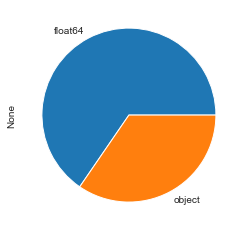

In [5]:
raw_data.dtypes.value_counts().plot.pie()

In [6]:
# analyse univarié
# prof = ProfileReport(raw_data)
# prof.to_file(output_file='rapport_prelim.html')

# Utlility function

In [117]:
def missing_values(df, missing_rate=100):
    missing = df.stb.missing()
    print(missing)
    print('-'*50)
    print('-'*50)
    print(df.stb.counts())
    clr = missing[missing['percent'] >= missing_rate]
    if not clr.empty:
        print(f"Missing {missing_rate}% data for : {len(clr)} features")
        print(clr.index)
        df.drop(clr.index, axis=1, inplace=True)
        return clr.index

def ts_clean(df):
    index = []
    bad_data = []
    for ind, val in df.items():
        if isinstance(val, int):
            # bad_data.append([ind, val])
            index.append(ind)
        elif isinstance(val, str):
            try:
                int(val)
                index.append(ind)
            except:
                bad_data.append([ind, val])
    print(len(bad_data), bad_data, sep='\n')
    return index

def dist_plot(df):
    plt.figure(figsize=(15,10))
    for col in df.select_dtypes('float'):

        sns.displot(df[col], kde=True)
        plt.title(f"Histogram for {col}")
        plt.show()
        
def check_inconsistent_data(df):
    index = []
    inconsistent_cells = []
    df1 = df.drop(['energy_100g'], axis=1)
    for row in df1.index:
        for col in df1.columns:
                value = df1.loc[row,col]
                if value < 0 or value > 100:
                    inconsistent_cells.append((value, (row,col)))
                    if row not in index:
                        index.append(row)
    print(df.iloc[index])
    return index
        
def fill_nutriments_with_0(df, cols):
    for col in cols:
        # not imputing energy 
        if not col.startswith('energy'):
            df[col] = df[col].fillna(0.)

def get_distance_for_product(df: any, file_name: str, list_prod: list, distance: float =  0.90):
    jaro_distance = []
    temp_df =df[df['pnns_groups_1'] != 'unknown']
    for str1 in tqdm.tqdm(list_prod, total=len(list_prod)):
        for i , str2 in temp_df['product_name'].dropna().items():
            dist = get_jaro_distance(str1[0], str2)
            if dist > distance:
                jaro_distance.append([i, str1[1], [str1[0], str2]])
    print(len(jaro_distance))
    df_new = pd.DataFrame(columns=['val_index', 'cat', 'compared_strings'], data=jaro_distance)
    df_new.to_csv(file_name + '.csv', index=False)

def get_cat(df: any, num_product: int, distance: float = 0.90):
    jaro_distance = []
    cat = ['beverages',
           'cereals and potatoes',
           'composite foods',
           'fat and sauces',
           'fish meat eggs',
           'fruits and vegetables',
           'milk and dairy products',
           'salty snacks',
           'sugary snacks',
           ]
    grouped = df[df['pnns_groups_1'] == 'unknown'].groupby('pnns_groups_1')['product_name'].value_counts(
        normalize=True).reset_index(
        name='norm')
    df_temp = grouped.head(num_product)
    for u in tqdm.tqdm(cat, total=len(cat)):
        str_to_compare = df[df['pnns_groups_1'] == u]['product_name'].dropna()
        for str1 in tqdm.tqdm(str_to_compare.values, total=len(str_to_compare.values)):
            for i, str2 in df_temp['product_name'].items():
                dist = get_jaro_distance(str1, str2)
                if dist > distance:
                    jaro_distance.append([str2, u, [str1, str2]])
    print(f'Total words/cat found : {len(jaro_distance)}', '-'*50, jaro_distance, sep="\n")
    return jaro_distance

def imputation_by_mean(df: any, col: str): # imputation par groupe homogène
    group = data.groupby('pnns_groups_1')[col].mean().round(0)
    ind = data[data[col].isna() == True]['pnns_groups_1']
    group_ind = ind.index.groupby(ind.values)
    for i, v in group.items():
        df.loc[group_ind[i], col] = v

In [8]:
data = raw_data.copy()

In [9]:
# Dropping features with no data
missing_values(data)
data.shape

                                            missing   total     percent
water-hardness_100g                          320772  320772  100.000000
no_nutriments                                320772  320772  100.000000
ingredients_that_may_be_from_palm_oil        320772  320772  100.000000
nutrition_grade_uk                           320772  320772  100.000000
nervonic-acid_100g                           320772  320772  100.000000
erucic-acid_100g                             320772  320772  100.000000
mead-acid_100g                               320772  320772  100.000000
elaidic-acid_100g                            320772  320772  100.000000
butyric-acid_100g                            320772  320772  100.000000
caproic-acid_100g                            320772  320772  100.000000
ingredients_from_palm_oil                    320772  320772  100.000000
lignoceric-acid_100g                         320772  320772  100.000000
cerotic-acid_100g                            320772  320772  100

(320772, 146)

<AxesSubplot:>

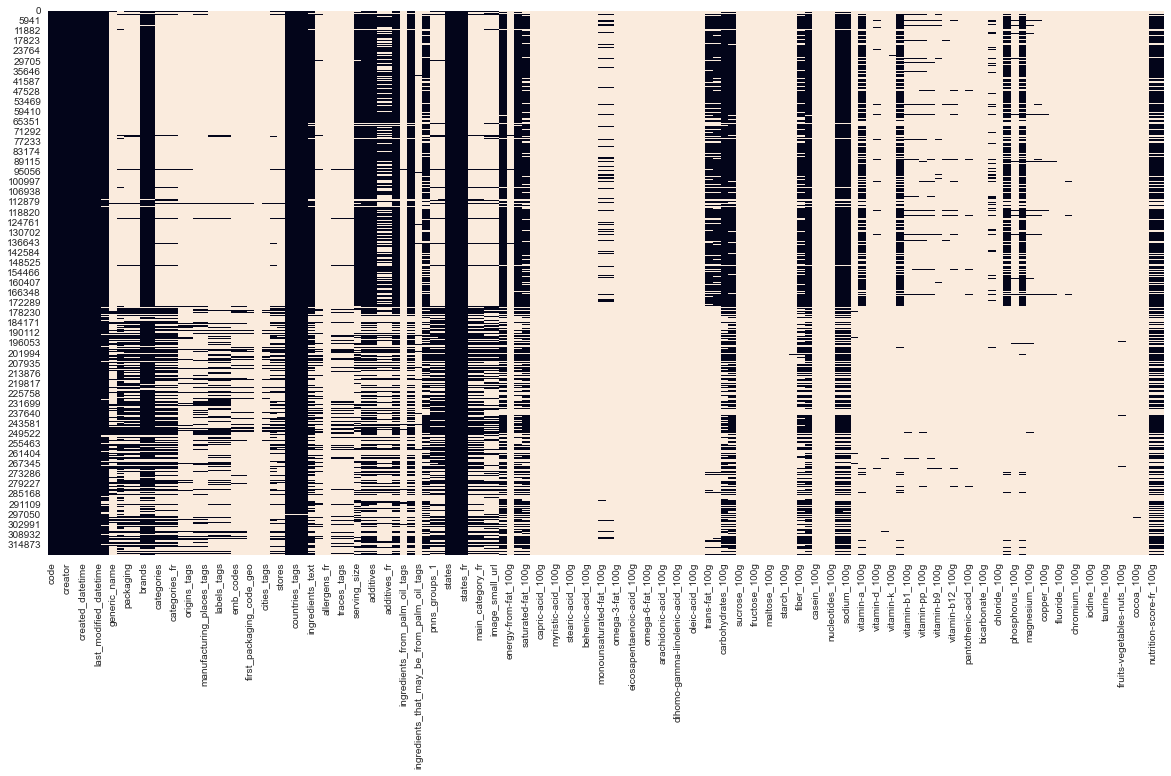

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(data.isna(), cbar=False)

# Découverte du module missingno

<AxesSubplot:>

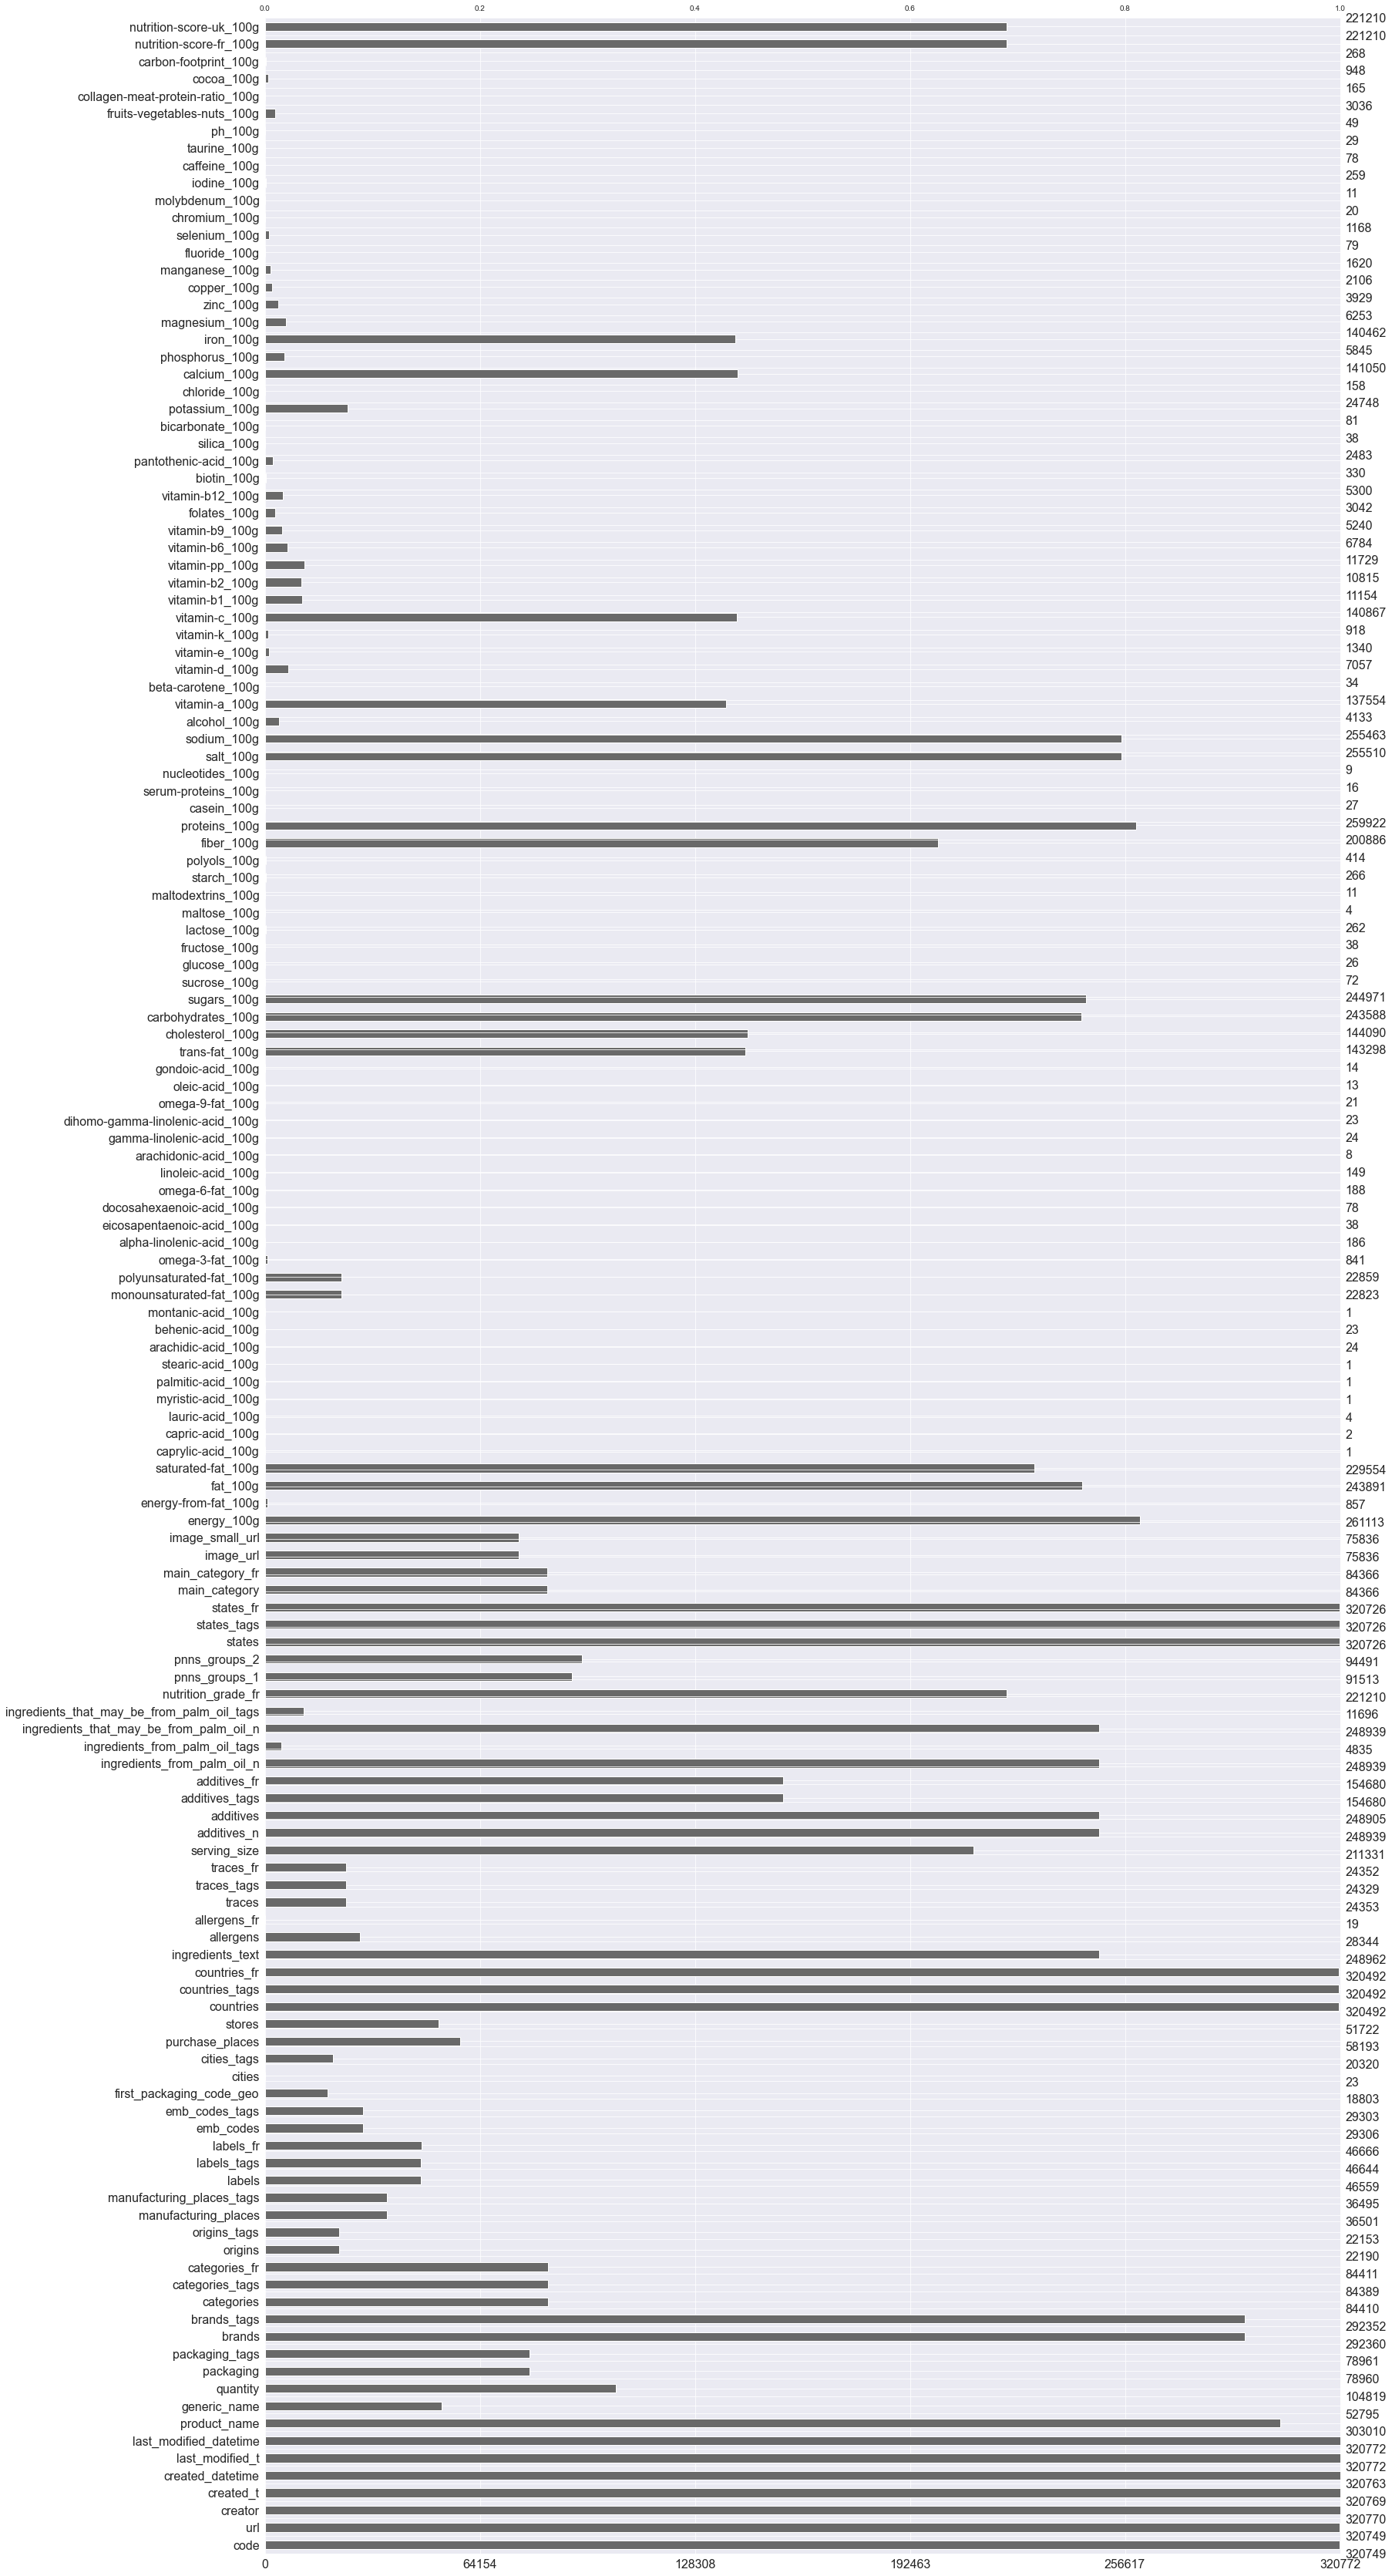

In [11]:
msno.bar(data)

# Groupe 1

In [12]:
data.loc[data['code'].duplicated(), : ]

code                                                url  \
481             16117  http://world-fr.openfoodfacts.org/produit/0001...   
519             24600  http://world-fr.openfoodfacts.org/produit/0002...   
560             31233  http://world-fr.openfoodfacts.org/produit/0003...   
632             58001  http://world-fr.openfoodfacts.org/produit/0005...   
1337       9800800056  http://world-fr.openfoodfacts.org/produit/0009...   
1343       9800892204  http://world-fr.openfoodfacts.org/produit/0009...   
2877      11110676177  http://world-fr.openfoodfacts.org/produit/0011...   
4547      11110881373  http://world-fr.openfoodfacts.org/produit/0011...   
6585      11152021409  http://world-fr.openfoodfacts.org/produit/0011...   
9892            11778  http://world-fr.openfoodfacts.org/produit/0011...   
13067     16073123454  http://world-fr.openfoodfacts.org/produit/0016...   
13384     16571910310  http://world-fr.openfoodfacts.org/produit/0016...   
13391     16571940331  http://world-fr.openfoodfacts.org/produit/0016...   
13392     16571940348  http://world-fr.openfoodfacts.org/produit/0016...   
13394     16571950293  http://world-fr.openfoodfacts.org/produit/0016...   
13395     16571950316  http://world-fr.openfoodfacts.org/produit/0016...   
13396     16571950842  http://world-fr.openfoodfacts.org/produit/0016...   
19029     21500011907  http://world-fr.openfoodfacts.org/produit/0021...   
19063     21500042161  http://world-fr.openfoodfacts.org/produit/0021...   
19064     21500042178  http://world-fr.openfoodfacts.org/produit/0021...   
20399     23923201965  http://world-fr.openfoodfacts.org/produit/0023...   
21580     24463061071  http://world-fr.openfoodfacts.org/produit/0024...   
21583     24463061163  http://world-fr.openfoodfacts.org/produit/0024...   
22824     26700129155  http://world-fr.openfoodfacts.org/produit/0026...   
27052     31200029997  http://world-fr.openfoodfacts.org/produit/0031...   
34613     37600105033  http://world-fr.openfoodfacts.org/produit/0037...   
34644     37600110754  http://world-fr.openfoodfacts.org/produit/0037...   
51325     41500007007  http://world-fr.openfoodfacts.org/produit/0041...   
62640     51651093651  http://world-fr.openfoodfacts.org/produit/0051...   
64799     52603965712  http://world-fr.openfoodfacts.org/produit/0052...   
66964       609962037  http://world-fr.openfoodfacts.org/produit/0060...   
68280     69276020235  http://world-fr.openfoodfacts.org/produit/0069...   
68290     69276070056  http://world-fr.openfoodfacts.org/produit/0069...   
71863     70650800091  http://world-fr.openfoodfacts.org/produit/0070...   
71872     70650800312  http://world-fr.openfoodfacts.org/produit/0070...   
71874     70650800367  http://world-fr.openfoodfacts.org/produit/0070...   
77489     71828001234  http://world-fr.openfoodfacts.org/produit/0071...   
79567     72220008586  http://world-fr.openfoodfacts.org/produit/0072...   
79568     72220008593  http://world-fr.openfoodfacts.org/produit/0072...   
79578     72220009941  http://world-fr.openfoodfacts.org/produit/0072...   
79579     72220009989  http://world-fr.openfoodfacts.org/produit/0072...   
80834     72457990227  http://world-fr.openfoodfacts.org/produit/0072...   
83154     73214001156  http://world-fr.openfoodfacts.org/produit/0073...   
83165     73214001347  http://world-fr.openfoodfacts.org/produit/0073...   
87709     74880030013  http://world-fr.openfoodfacts.org/produit/0074...   
87711     74880030037  http://world-fr.openfoodfacts.org/produit/0074...   
87732     74880070033  http://world-fr.openfoodfacts.org/produit/0074...   
91156     76186000028  http://world-fr.openfoodfacts.org/produit/0076...   
91723       764114944  http://world-fr.openfoodfacts.org/produit/0076...   
99206     78895300024  http://world-fr.openfoodfacts.org/produit/0078...   
99408     79122112502  http://world-fr.openfoodfacts.org/produit/0079...   
101229    82592194152  http://world-fr.openfoodfacts.org/produit/

In [13]:
pd.concat(g for _, g in data.groupby("code") if len(g) > 1)

code                                                url  \
458             11778  http://world-fr.openfoodfacts.org/produit/0001...   
9892            11778  http://world-fr.openfoodfacts.org/produit/0011...   
6               16117  http://world-fr.openfoodfacts.org/produit/0000...   
481             16117  http://world-fr.openfoodfacts.org/produit/0001...   
46              24600  http://world-fr.openfoodfacts.org/produit/0000...   
...               ...                                                ...   
169195   876045004026  http://world-fr.openfoodfacts.org/produit/0876...   
115938  4711567123489  http://world-fr.openfoodfacts.org/produit/0471...   
268065  4711567123489  http://world-fr.openfoodfacts.org/produit/4711...   
116492  5400141350470  http://world-fr.openfoodfacts.org/produit/0540...   
276819  5400141350470  http://world-fr.openfoodfacts.org/produit/5400...   

                  creator   created_t      created_datetime last_modified_t  \
458               gildubs  1490975915  2017-03-31T15:58:35Z      1490976772   
9892              beniben  1474489149  2016-09-21T20:19:09Z      1491142385   
6         usda-ndb-import  1489055730  2017-03-09T10:35:30Z      1489055730   
481       usda-ndb-import  1489065258  2017-03-09T13:14:18Z      1489065258   
46        date-limite-app  1434530704  2015-06-17T08:45:04Z      1434535914   
...                   ...         ...                   ...             ...   
169195    usda-ndb-import  1489060713  2017-03-09T11:58:33Z      1489060714   
115938    usda-ndb-import  1489142865  2017-03-10T10:47:45Z      1489142865   
268065    usda-ndb-import  1489097363  2017-03-09T22:09:23Z      1489097363   
116492             emerzh  1484997881  2017-01-21T11:24:41Z      1484998804   
276819  gauthier-de-geest  1481365048  2016-12-10T10:17:28Z      1485724198   

       last_modified_datetime                                 product_name  \
458      2017-03-31T16:12:52Z                          Stem Ginger Cookies   
9892     2017-04-02T14:13:05Z   All Butter Reduced Fat Stem Ginger Cookies   
6        2017-03-09T10:35:30Z                Organic Long Grain White Rice   
481      2017-03-09T13:14:18Z        Colossal Olives With Jalapeno Peppers   
46       2015-06-17T10:11:54Z                                Filet de bœuf   
...                       ...                                          ...   
169195   2017-03-09T11:58:34Z                Smokey & Sweet Barbeque Sauce   
115938   2017-03-10T10:47:45Z  Dainty Food Co, Chili Sauce With Black Bean   
268065   2017-03-09T22:09:23Z                  Chile Sauce With Black Bean   
116492   2017-01-21T11:40:04Z                                Cereal flakes   
276819   2017-01-29T21:09:58Z                 Cribbits Rice & Wheat Flakes   

                                             generic_name            quantity  \
458     cookies au beurre à teneur réduite en matières...  225 g (10 cookies)   
9892                                                  NaN               225 g   
6                                                     NaN                 NaN   
481                                                   NaN                 NaN   
46                                                    NaN             2.46 kg   
...                                                   ...                 ...   
169195                                                NaN                 NaN   
115938                                                NaN                 NaN   
268065                                                NaN                 NaN   
116492                                                NaN               500 g   
276819                                                NaN                 NaN   

               packaging    packaging_tags                       brands  \
458            plastique         plastique              Marks & Spencer   
9892    Plastique,Sachet  plastique,sachet              Marks & Spencer   
6                   

In [14]:
data.drop(data.loc[data['code'].duplicated(), : ].index, axis=0, inplace=True)

In [15]:
data.drop(['code', 'url', 'creator'], axis=1, inplace=True)

# Groupe 2 temporalité

In [16]:
df_temp = data[['created_t','last_modified_t','created_datetime','last_modified_datetime']]

In [17]:
c_d = df_temp[df_temp['created_datetime'].str.contains('2') != True]
data.iloc[c_d.index]

created_t      created_datetime last_modified_t  \
187567  1474967642  2016-09-27T09:14:02Z      1489746871   
189163  1393258670  2014-02-24T16:17:50Z      1438186152   

       last_modified_datetime              product_name  \
187567   2017-03-17T10:34:31Z             Petit ecolier   
189163   2015-07-29T16:09:12Z  Activia (Nature) 16 Pots   

                           generic_name                quantity  \
187567                              NaN                       1   
189163  Lait fermenté nature au Bifidus  2 kg [2 x (8 x 125 g)]   

                                              packaging  \
187567                                              NaN   
189163  Frais,Pot,Plastique,Opercule,Papier,Etui,Carton   

                                         packaging_tags          brands  \
187567                                              NaN              Lu   
189163  frais,pot,plastique,opercule,papier,etui,carton  Danone,Activia   

           brands_tags                                         categories  \
187567              lu                                                NaN   
189163  danone,activia  Frais,Produits laitiers,Desserts,Yaourts,Yaour...   

                                          categories_tags  \
187567                                                NaN   
189163  en:fresh-foods,en:dairies,en:desserts,en:yogur...   

                                            categories_fr origins  \
187567                                                NaN     NaN   
189163  Frais,Produits laitiers,Desserts,Yaourts,Yaour...     NaN   

       origins_tags                               manufacturing_places  \
187567          NaN                                                NaN   
189163          NaN  Danone Produits Frais France (DPFF) - 300 Allé...   

                                manufacturing_places_tags labels labels_tags  \
187567                                                NaN    NaN         NaN   
189163  danone-produits-frais-france-dpff-300-allee-de...    NaN         NaN   

       labels_fr         emb_codes    emb_codes_tags first_packaging_code_geo  \
187567       NaN               NaN               NaN                      NaN   
189163       NaN  FR 59.043.030 EC  fr-59-043-030-ec       50.733333,2.733333   

       cities           cities_tags purchase_places     stores  \
187567    NaN                   NaN             NaN        NaN   
189163    NaN  bailleul-nord-france          France  Carrefour   

              countries        countries_tags     countries_fr  \
187567           France             en:france           France   
189163  Belgique,France  en:belgium,en:france  Belgique,France   

                                         ingredients_text         allergens  \
187567                                                NaN               NaN   
189163  _Lait_ entier, _lait_ écrémé en poudre, fermen...  Lait, lait, lait   

       allergens_fr traces traces_tags traces_fr   serving_size  additives_n  \
187567          NaN    NaN         NaN       NaN            NaN          NaN   
189163          NaN    NaN         NaN       NaN  1 pot (125 g)          0.0   

                                                additives additives_tags  \
187567                                                NaN            NaN   
189163   [ lait-entier -> fr:lait-entier  ]  [ lait ->...            NaN   

       additives_fr  ingredients_from_palm_oil_n  \
187567          NaN                          NaN   
189163          NaN                          0.0   

       ingredients_from_palm_oil_tags  \
187567                            NaN   
189163                            NaN   

        ingredients_that_may_be_from_palm_oil_n  \
187567                                      NaN   
189163                                      0.0   

       ingredients_that_may_be_from_palm_oil_tags nutrition_grade_fr  \
187567                                        NaN                  e   
189163                     

In [18]:
data.drop(c_d.index, inplace=True)
df_temp.drop(c_d.index, inplace=True)

In [19]:
# l_d = df_temp[df_temp['last_modified_datetime'].str.contains('2') != True]
df_temp['created_datetime'] = pd.to_datetime(df_temp['created_datetime'])
data['created_datetime'] = pd.to_datetime(data['created_datetime'])
data['last_modified_datetime'] = pd.to_datetime(data['last_modified_datetime'])
df_temp['last_modified_datetime'] = pd.to_datetime(df_temp['last_modified_datetime'])
df_temp.dtypes.value_counts()

object                 2
datetime64[ns, UTC]    2
dtype: int64

In [20]:
index = ts_clean(df_temp['created_t'])
df_temp.loc[index, 'created_t'] = pd.to_datetime(df_temp.loc[index, 'created_t'], unit='s')
df_temp['created_t'].head()

0
[]


0   2016-09-17 09:17:46
1   2017-03-09 14:32:37
2   2017-03-09 14:32:37
3   2017-03-09 10:35:31
4   2017-03-09 10:34:13
Name: created_t, dtype: datetime64[ns]

In [21]:
index = ts_clean(df_temp['last_modified_t'])
df_temp.loc[index, 'last_modified_t'] = pd.to_datetime(df_temp.loc[index, 'last_modified_t'], unit='s')
df_temp['last_modified_t'].head()

0
[]


0   2016-09-17 09:18:13
1   2017-03-09 14:32:37
2   2017-03-09 14:32:37
3   2017-03-09 10:35:31
4   2017-03-09 10:34:13
Name: last_modified_t, dtype: datetime64[ns]

In [22]:
df_temp['created_datetime'].agg(['min', 'max'])

min   2012-01-31 14:43:58+00:00
max   2017-04-21 01:15:03+00:00
Name: created_datetime, dtype: datetime64[ns, UTC]

In [23]:
df_temp['last_modified_datetime'].agg(['min', 'max'])

min   2012-03-21 22:15:32+00:00
max   2017-04-21 01:15:04+00:00
Name: last_modified_datetime, dtype: datetime64[ns, UTC]

In [24]:
data.drop(['created_datetime', 'last_modified_t', 'last_modified_datetime', 'created_t'], axis=1, inplace=True)
data.shape

(320637, 139)

# Groupe 3

In [25]:
df_cat = data[['product_name','generic_name', 'first_packaging_code_geo', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr',
               'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_fr']]
df_cat.shape

(320637, 19)

In [26]:
for col in df_cat.columns:
    df_cat[col] = df_cat[col].str.lower()
    data[col] = data[col].str.lower()

df_cat['pnns_groups_1'] = df_cat['pnns_groups_1'].replace({'-': ' '}, regex=True)
data['pnns_groups_1'] = data['pnns_groups_1'].replace({'-': ' '}, regex=True)
data['pnns_groups_1'].fillna('unknown', inplace=True)
df_cat['pnns_groups_1'].fillna('unknown', inplace=True)

In [27]:
data['pnns_groups_1'].value_counts()

unknown                    251763
sugary snacks               12859
beverages                    9031
milk and dairy products      8825
cereals and potatoes         8456
fish meat eggs               8040
fruits and vegetables        6895
composite foods              6746
fat and sauces               5213
salty snacks                 2809
Name: pnns_groups_1, dtype: int64

In [28]:
df_cat.replace({'en:': '', 'fr:': '', 'de:': ''}, regex=True, inplace=True)
data.replace({'en:': '', 'fr:': '', 'de:': ''}, regex=True, inplace=True)

In [29]:
df_cat.stb.counts()

count  unique  \
pnns_groups_1             320637      10   
pnns_groups_2              94474      37   
first_packaging_code_geo   18803    1602   
main_category_fr           84350    3432   
main_category              84350    3446   
emb_codes_tags             29301    8156   
emb_codes                  29305    8461   
packaging_tags             78946   12064   
packaging                  78945   12503   
labels_tags                46630   13573   
labels_fr                  46630   13587   
labels                     46545   17327   
categories_tags            84373   21000   
categories_fr              84373   21028   
categories                 84373   35248   
generic_name               52766   36970   
brands_tags               292256   50236   
brands                    292264   53953   
product_name              302881  214385   

                                                                  most_freq  \
pnns_groups_1                                                       unknown   
pnns_groups_2                                                       unknown   
first_packaging_code_geo                                47.633333,-2.666667   
main_category_fr                                                   boissons   
main_category                                                     beverages   
emb_codes_tags                                                   emb-56251e   
emb_codes                                                        emb 56251e   
packaging_tags                                             sachet,plastique   
packaging                                                  sachet,plastique   
labels_tags                    organic,eu-organic,ab-agriculture-biologique   
labels_fr                        bio,bio européen,ab agriculture biologique   
labels                       organic, eu organic, ab agriculture biologique   
categories_tags                   sugary-snacks,biscuits-and-cakes,biscuits   
categories_fr                    snacks sucrés,biscuits et gâteaux,biscuits   
categories                                                         biscuits   
generic_name              pâtes alimentaires au blé dur de qualité supér...   
brands_tags                                                       carrefour   
brands                                                            carrefour   
product_name                                                      ice cream   

                          most_freq_count  \
pnns_groups_1                      251763   
pnns_groups_2                       22623   
first_packaging_code_geo              279   
main_category_fr                     6057   
main_category                        6053   
emb_codes_tags                        218   
emb_codes                             218   
packaging_tags                       3959   
packaging                            3959   
labels_tags                          5318   
labels_fr                            5311   
labels                               3223   
categories_tags                       801   
categories_fr                         801   
categories                            317   
generic_name                          201   
brands_tags                          3149   
brands                               3084   
product_name                          413   

                                                                 least_freq  \
pnns_groups_1                                                  salty snacks   
pnns_groups_2                                      salty and fatty products   
first_packaging_code_geo                                 49.983333,2.683333   
main_category_fr                                                     punsch   
main_category                                                   foi-de-viță   
emb_codes_tags                                                     it-54-ec   
emb_codes                                                       uk sr003 ec   
packaging_tags                  

In [30]:
df_cat.stb.missing()

missing   total    percent
first_packaging_code_geo   301834  320637  94.135736
emb_codes_tags             291336  320637  90.861629
emb_codes                  291332  320637  90.860381
labels                     274092  320637  85.483584
labels_tags                274007  320637  85.457075
labels_fr                  274007  320637  85.457075
generic_name               267871  320637  83.543384
packaging                  241692  320637  75.378699
packaging_tags             241691  320637  75.378387
main_category_fr           236287  320637  73.692992
main_category              236287  320637  73.692992
categories_fr              236264  320637  73.685819
categories_tags            236264  320637  73.685819
categories                 236264  320637  73.685819
pnns_groups_2              226163  320637  70.535528
brands_tags                 28381  320637   8.851443
brands                      28373  320637   8.848948
product_name                17756  320637   5.537726
pnns_groups_1                   0  320637   0.000000

In [31]:
# df_cat_jaro = pd.read_csv('cat.csv')
df_cat_jaro = pd.concat(
    [pd.read_csv('resu1.csv'), pd.read_csv('resu.csv'), pd.read_csv('resu2.csv'), pd.read_csv('resu3.csv'),
     pd.read_csv('resu5.csv'), pd.read_csv('resu4.csv'), pd.read_csv('resu6.csv'), pd.read_csv('resu7.csv')], ignore_index=True)
df_cat_jaro.drop(df_cat_jaro[df_cat_jaro['val_index'].duplicated()].index, axis=0, inplace=True)
dup =[189364, 237299, 263820, 174391, 175235, 189362, 189248, 276819, 229431, 168878, 176993, 189262, 189250, 189269, 189244, 189242, 251107, 560, 189109, 189119, 175025, 87709, 189160, 1337, 21583, 189406, 174990, 481, 79579, 4547, 64799, 80834, 1343, 34644, 101254, 138216, 175026, 280571, 280572, 237298, 134825, 27052, 13384, 13391, 34613, 83154, 77489, 264016, 19063, 19064, 187478, 262433, 62640, 71874, 138211, 79568, 300376, 68280, 91156, 161112, 174719, 21580, 68290, 79578, 6585, 71863, 83165, 177550, 99206, 138106, 189272, 120390, 275202]
df_cat_jaro.drop(df_cat_jaro[df_cat_jaro['val_index'].isin(dup)].index, axis=0, inplace=True)
data.loc[df_cat_jaro['val_index'].values.tolist(), 'pnns_groups_1'] = df_cat_jaro['cat'].values.tolist()

In [32]:
ind = data[data['product_name'] == 'ice cream'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'extra virgin olive oil'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'potato chips'].index
data.loc[ind, 'pnns_groups_1'] = 'salty snacks'
ind = data[data['product_name'] == 'premium ice cream'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'popcorn'].index
data.loc[ind, 'pnns_groups_1'] = 'sugary snacks'
ind = data[data['product_name'] == 'beef jerky'].index
data.loc[ind, 'pnns_groups_1'] = 'fish meat eggs'
ind = data[data['product_name'] == 'cookies'].index
data.loc[ind, 'pnns_groups_1'] = 'sugary snacks'
ind = data[data['product_name'] == 'pinto beans'].index
data.loc[ind, 'pnns_groups_1'] = 'fruits and vegetables'
ind = data[data['product_name'] == 'salsa'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'creamy peanut butter'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'tomato ketchup'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'candy'].index
data.loc[ind, 'pnns_groups_1'] = 'sugary snacks'
ind = data[data['product_name'] == 'granola'].index
data.loc[ind, 'pnns_groups_1'] = 'sugary snacks'
ind = data[data['product_name'] == 'milk chocolate'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'chicken broth'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'apple sauce'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'cut green beans'].index
data.loc[ind, 'pnns_groups_1'] = 'fruits and vegetables'
ind = data[data['product_name'] == 'black beans'].index
data.loc[ind, 'pnns_groups_1'] = 'fruits and vegetables'
ind = data[data['product_name'] == 'protein bar'].index
data.loc[ind, 'pnns_groups_1'] = 'sugary snacks'
ind = data[data['product_name'] == '2% reduced fat milk'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'cottage cheese'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'soda'].index
data.loc[ind, 'pnns_groups_1'] = 'beverages'
ind = data[data['product_name'] == 'chunk light tuna in water'].index
data.loc[ind, 'pnns_groups_1'] = 'fish meat eggs'
ind = data[data['product_name'] == 'gelato'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'tomato sauce'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'greek nonfat yogurt'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'icing decorations'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'sparkling water'].index
data.loc[ind, 'pnns_groups_1'] = 'beverages'
ind = data[data['product_name'] == 'tortilla chips'].index
data.loc[ind, 'pnns_groups_1'] = 'salty snacks'
ind = data[data['product_name'] == 'dark chocolate'].index
data.loc[ind, 'pnns_groups_1'] = 'sugary snacks'
ind = data[data['product_name'] == 'fat free milk'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'raw shrimp'].index
data.loc[ind, 'pnns_groups_1'] = 'fish meat eggs'
ind = data[data['product_name'] == 'sharp cheddar cheese'].index
data.loc[ind, 'pnns_groups_1'] = 'milk and dairy products'
ind = data[data['product_name'] == 'yellow mustard'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'hot sauce'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'mixed nuts'].index
data.loc[ind, 'pnns_groups_1'] = 'salty snacks'
ind = data[data['product_name'] == 'pasta sauce'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'sauce'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'frosted sugar cookies'].index
data.loc[ind, 'pnns_groups_1'] = 'sugary snacks'
ind = data[data['product_name'] == 'trail mix'].index
data.loc[ind, 'pnns_groups_1'] = 'composite foods'
ind = data[data['product_name'] == 'mixed vegetables'].index
data.loc[ind, 'pnns_groups_1'] = 'fruits and vegetables'
ind = data[data['product_name'] == 'cooked shrimp'].index
data.loc[ind, 'pnns_groups_1'] = 'composite foods'
ind = data[data['product_name'] == 'bbq sauce'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'canola oil'].index
data.loc[ind, 'pnns_groups_1'] = 'fat and sauces'
ind = data[data['product_name'] == 'sweet peas'].index
data.loc[ind, 'pnns_groups_1'] = 'fruits and vegetables'

In [33]:
data['pnns_groups_1'].value_counts()

unknown                    105392
fat and sauces              41462
beverages                   34085
milk and dairy products     25264
cereals and potatoes        25072
sugary snacks               23751
fruits and vegetables       19746
salty snacks                16722
composite foods             15001
fish meat eggs              14142
Name: pnns_groups_1, dtype: int64

In [34]:
data.groupby('pnns_groups_1').size().cumsum()

pnns_groups_1
beverages                   34085
cereals and potatoes        59157
composite foods             74158
fat and sauces             115620
fish meat eggs             129762
fruits and vegetables      149508
milk and dairy products    174772
salty snacks               191494
sugary snacks              215245
unknown                    320637
dtype: int64

<AxesSubplot:xlabel='pnns_groups_1'>

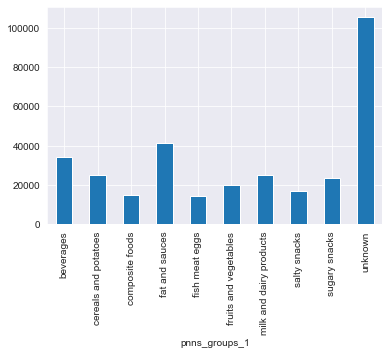

In [35]:
data.groupby('pnns_groups_1').size().plot(kind='bar')

In [36]:
grouped = data.groupby('pnns_groups_1')['product_name'].value_counts(
    normalize=True).reset_index(
    name='norm')
grouped[grouped['norm'] > 0.001]

pnns_groups_1               product_name      norm
0                     beverages                       soda  0.003152
1                     beverages            sparkling water  0.002540
2                     beverages                  spaghetti  0.001224
48935           composite foods                  trail mix  0.007108
48936           composite foods              cooked shrimp  0.004948
62038            fat and sauces     extra virgin olive oil  0.007732
62039            fat and sauces             tomato ketchup  0.005104
62040            fat and sauces                      salsa  0.003778
62041            fat and sauces               tomato sauce  0.003578
62042            fat and sauces       creamy peanut butter  0.003303
62043            fat and sauces                apple sauce  0.003078
62044            fat and sauces                pasta sauce  0.002777
62045            fat and sauces              chicken broth  0.002702
62046            fat and sauces                  hot sauce  0.002502
62047            fat and sauces                  bbq sauce  0.002177
62048            fat and sauces             yellow mustard  0.002002
62049            fat and sauces                 canola oil  0.001802
62050            fat and sauces                      sauce  0.001727
94344            fish meat eggs                 beef jerky  0.012403
94345            fish meat eggs                 raw shrimp  0.006758
94346            fish meat eggs  chunk light tuna in water  0.006535
106121    fruits and vegetables                pinto beans  0.008535
106122    fruits and vegetables            cut green beans  0.007428
106123    fruits and vegetables                black beans  0.007060
106124    fruits and vegetables           mixed vegetables  0.004952
106125    fruits and vegetables                 sweet peas  0.004847
106126    fruits and vegetables                 framboises  0.001106
122222  milk and dairy products                  ice cream  0.016958
122223  milk and dairy products          premium ice cream  0.009279
122224  milk and dairy products             milk chocolate  0.005132
122225  milk and dairy products             cottage cheese  0.004763
122226  milk and dairy products        2% reduced fat milk  0.004352
122227  milk and dairy products        greek nonfat yogurt  0.004352
122228  milk and dairy products       sharp cheddar cheese  0.003777
122229  milk and dairy products                     gelato  0.003326
122230  milk and dairy products              fat free milk  0.003162
122231  milk and dairy products          icing decorations  0.002792
122232  milk and dairy products           lait demi-écrémé  0.001109
122233  milk and dairy products          frische vollmilch  0.001068
142679             salty snacks               potato chips  0.017548
142680             salty snacks             tortilla chips  0.008243
142681             salty snacks                 mixed nuts  0.005121
156671            sugary snacks                    popcorn  0.006995
156672            sugary snacks                    cookies  0.006863
156673            sugary snacks                      candy  0.005147
156674            sugary snacks                protein bar  0.004663
156675            sugary snacks                    granola  0.004443
156676            sugary snacks             dark chocolate  0.004092
156677            sugary snacks      frosted sugar cookies  0.003916
156678            sugary snacks                    nutella  0.001012

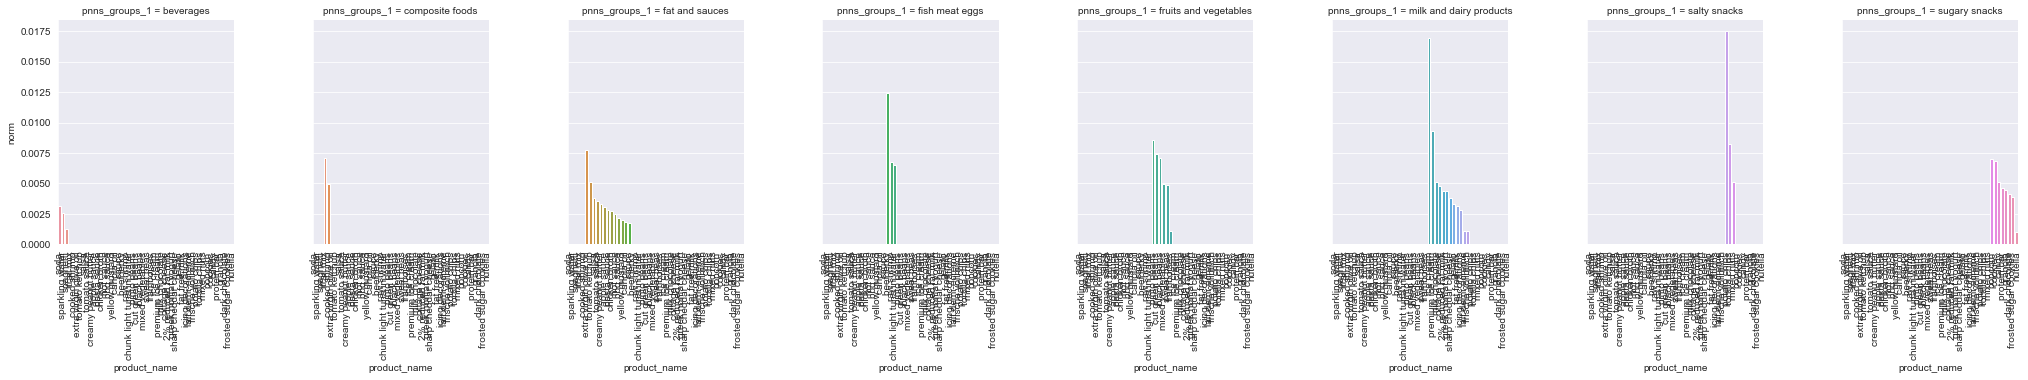

In [37]:
g = sns.catplot(x='product_name', y='norm', col='pnns_groups_1', data=grouped[grouped['norm'] > 0.001], kind='bar',
                height=4, aspect=0.9)
# g.fig.set_size_inches(30,3)
g.set_xticklabels(rotation=90)

In [38]:
data.drop(['first_packaging_code_geo', 'emb_codes', 'emb_codes_tags', 'packaging', 'packaging_tags'], axis=1, inplace=True)

In [39]:
# je supprime aussi les colonnes états et img url
data.drop(['states', 'states_tags', 'states_fr', 'image_url', 'image_small_url'], axis=1, inplace=True)

# Groupe 4

In [40]:
df_al = data[['allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr']]
df_al.shape

(320637, 5)

In [41]:
df_al.stb.missing()

missing   total     percent
allergens_fr   320637  320637  100.000000
traces_tags    296312  320637   92.413539
traces_fr      296312  320637   92.413539
traces         296311  320637   92.413227
allergens      292318  320637   91.167894

In [42]:
data.drop(['allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr'], axis=1, inplace=True)

In [43]:
data.shape

(320637, 124)

# Groupe 5

In [44]:
df_loc = data[['origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr']]
df_loc.shape

(320637, 11)

In [45]:
df_loc.stb.missing()

missing   total     percent
cities                      320637  320637  100.000000
cities_tags                 300340  320637   93.669789
origins_tags                298509  320637   93.098738
origins                     298472  320637   93.087198
manufacturing_places_tags   284172  320637   88.627326
manufacturing_places        284166  320637   88.625455
stores                      268947  320637   83.878966
purchase_places             262478  320637   81.861420
countries                      280  320637    0.087326
countries_tags                 280  320637    0.087326
countries_fr                   280  320637    0.087326

In [46]:
data.drop(['origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'cities', 'cities_tags', 'purchase_places', 'stores'
           ], axis=1, inplace=True)

In [47]:
df_loc['countries'].value_counts().sort_values(ascending=False)

US                                         170604
France                                      77289
FR                                          17003
Suisse                                      12314
Deutschland                                  6160
                                            ...  
France, united-states                           1
Kazakhstan                                      1
France,Suisse,Allemagne,Espagne                 1
Danemark,France,Belgien,Sverige, Suisse         1
Hong Kong,China                                 1
Name: countries, Length: 1415, dtype: int64

In [48]:
df_loc['countries_tags'].value_counts().sort_values(ascending=False)

united-states                                                  172911
france                                                          94386
switzerland                                                     14953
germany                                                          7869
spain                                                            5009
                                                                ...  
bosnia-and-herzegovina,croatia,republic-of-macedonia,serbia         1
hungary,spain                                                       1
morocco,spain                                                       1
france,guadeloupe,hungary,slovenia,united-kingdom                   1
china,hong-kong                                                     1
Name: countries_tags, Length: 713, dtype: int64

In [49]:
data.drop(['countries_tags', 'countries'], axis=1, inplace=True)

In [50]:
df_loc['countries_fr'].value_counts().sort_values(ascending=False)

États-Unis                 172911
France                      94386
Suisse                      14953
Allemagne                    7869
Espagne                      5009
                            ...  
Albanie,Danemark,Italie         1
Italie,Roumanie                 1
Belgique,Italie                 1
Géorgie                         1
Chine,Hong Kong                 1
Name: countries_fr, Length: 711, dtype: int64

In [51]:
df_loc['countries_fr'], df_loc['countries_fr_split'] = df_loc['countries_fr'].str.split(',', 1).str
df_loc['countries_fr_split'].value_counts().sort_values(ascending=False)

C:\Users\Alex\AppData\Local\Temp\ipykernel_2336\220273528.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_loc['countries_fr'], df_loc['countries_fr_split'] = df_loc['countries_fr'].str.split(',', 1).str


Suisse                                                                     1549
France                                                                      629
Royaume-Uni                                                                 603
États-Unis                                                                  389
Allemagne                                                                   294
                                                                           ... 
Hongrie,Royaume-Uni                                                           1
Croatie,Estonie,Allemagne,Grèce,Italie,Pays-Bas,Pologne,Serbie,Slovénie       1
Polynésie française,Nouvelle-Calédonie                                        1
Malaisie                                                                      1
République tchèque,France,Allemagne,Hongrie                                   1
Name: countries_fr_split, Length: 345, dtype: int64

In [52]:
data['countries_fr'], _ = data['countries_fr'].str.split(',', 1).str

C:\Users\Alex\AppData\Local\Temp\ipykernel_2336\1074862841.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data['countries_fr'], _ = data['countries_fr'].str.split(',', 1).str


In [53]:
data['countries_fr'].sample(20)

254491        France
210957        France
81825     États-Unis
215010        France
96792     États-Unis
167628    États-Unis
58969     États-Unis
264547        France
238217      Belgique
190114        France
65338     États-Unis
12797     États-Unis
190673        France
141074    États-Unis
152520    États-Unis
301523        France
37451     États-Unis
123386    États-Unis
173656    États-Unis
35913     États-Unis
Name: countries_fr, dtype: object

In [54]:
df_fr = data[data['countries_fr'] == 'France']
df_fr.shape

(97432, 114)

<AxesSubplot:>

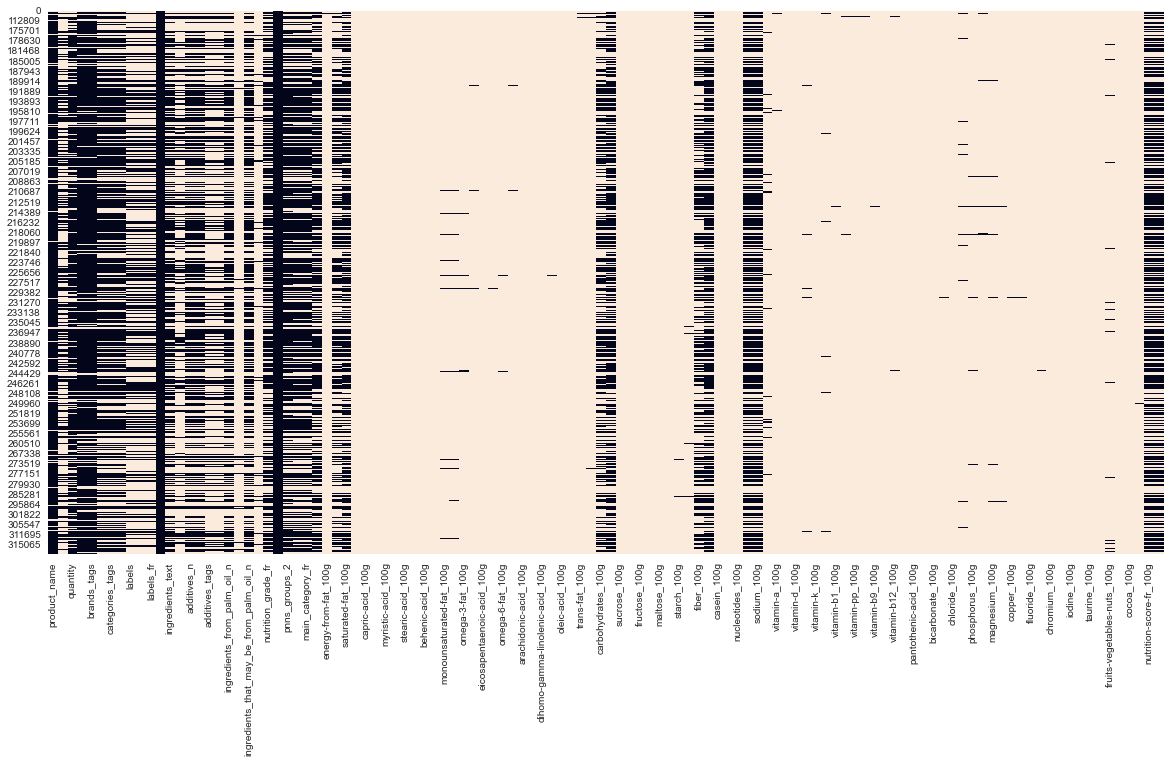

In [55]:
plt.figure(figsize=(20,10))
sns.heatmap(df_fr.isna(), cbar=False)

In [56]:
df_usa = data[data['countries_fr'] == 'États-Unis']
df_usa.shape

(172926, 114)

<AxesSubplot:>

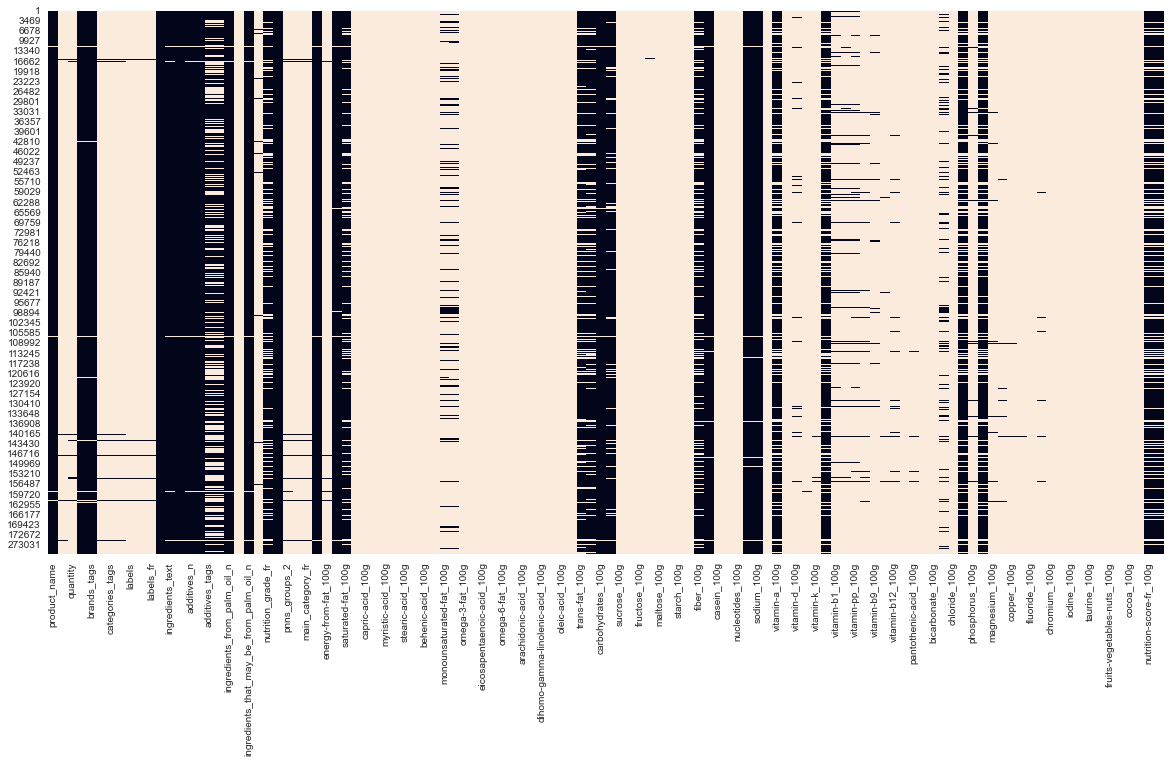

In [57]:
plt.figure(figsize=(20,10))
sns.heatmap(df_usa.isna(), cbar=False)

In [58]:
df_other = data[(data['countries_fr'] != 'États-Unis') & (data['countries_fr'] != 'France')]
df_other.shape

(50279, 114)

<AxesSubplot:>

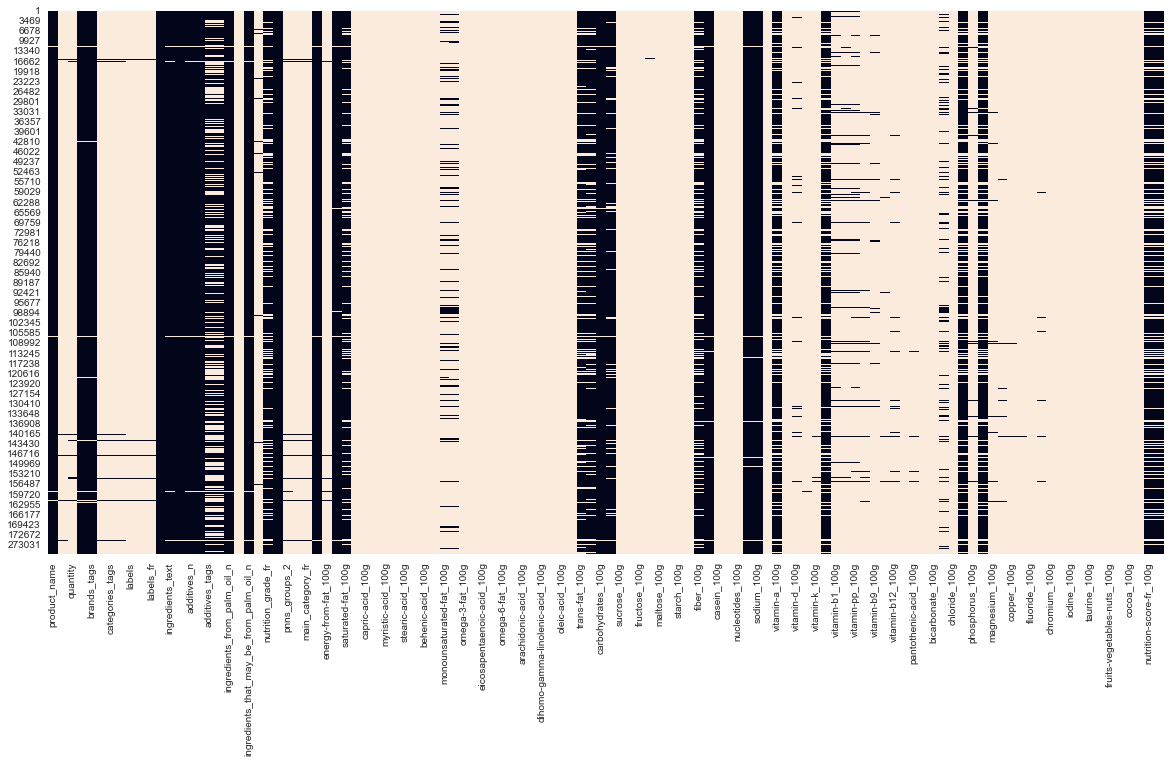

In [59]:
plt.figure(figsize=(20,10))
sns.heatmap(df_usa.isna(), cbar=False)

# Groupe 6

In [60]:
df_ad = data[['additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags']]
df_ad.shape

(320637, 8)

In [61]:
df_ad.stb.missing()

missing   total    percent
ingredients_from_palm_oil_tags               315802  320637  98.492064
ingredients_that_may_be_from_palm_oil_tags   308942  320637  96.352573
additives_tags                               166022  320637  51.778803
additives_fr                                 166022  320637  51.778803
additives                                     71822  320637  22.399785
additives_n                                   71788  320637  22.389182
ingredients_from_palm_oil_n                   71788  320637  22.389182
ingredients_that_may_be_from_palm_oil_n       71788  320637  22.389182

In [62]:
data.drop(['ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags'], axis=1, inplace=True)

In [63]:
df_ad.replace({'en:e': 'E'}, regex=True, inplace=True)
data.replace({'en:e': 'E'}, regex=True, inplace=True)

In [64]:
# Split de la colonne additives_tags

df_ad['additives_tags_split'] = df_ad['additives_tags'].str.split(',', -1)

In [65]:
# verification si la additives_n correspond au nbre additives_tags_split

for i, v in df_ad['additives_tags_split'].items():
    if isinstance(v, list) and len(v) == df_ad.loc[i, 'additives_n']:
        df_ad.loc[i, 'value'] = True
df_ad['value'].value_counts()

True    154615
Name: value, dtype: int64

In [66]:
imputation_by_mean(df_ad, 'additives_n')
imputation_by_mean(data, 'additives_n')

In [67]:
# remplacement des nan sur la col additives_tags

for i, v in data['additives_n'].items():
    if isinstance(v, float) and v == 0.:
        data.loc[i, 'additives_tags'] = 'No additives'
        df_ad.loc[i, 'additives_tags'] = 'No additives'

In [68]:
df_ad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320637 entries, 0 to 320771
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additives_n                                 320637 non-null  float64
 1   additives                                   248815 non-null  object 
 2   additives_tags                              248849 non-null  object 
 3   additives_fr                                154615 non-null  object 
 4   ingredients_from_palm_oil_n                 248849 non-null  float64
 5   ingredients_from_palm_oil_tags              4835 non-null    object 
 6   ingredients_that_may_be_from_palm_oil_n     248849 non-null  float64
 7   ingredients_that_may_be_from_palm_oil_tags  11695 non-null   object 
 8   additives_tags_split                        154615 non-null  object 
 9   value                                       154615 non-null  object 
d

<Figure size 1080x720 with 0 Axes>

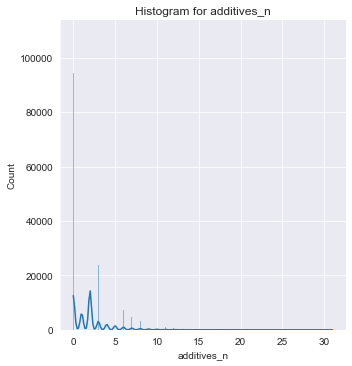

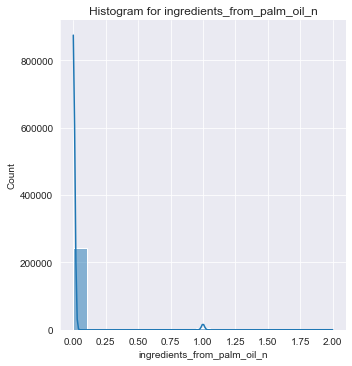

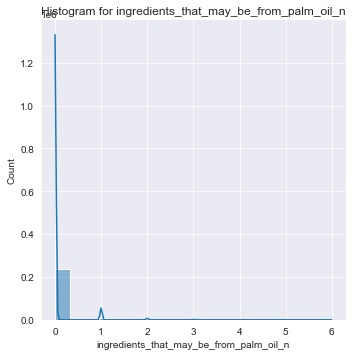

In [119]:
dist_plot(df_ad)

# Groupe 7

In [70]:
data.drop(['dihomo-gamma-linolenic-acid_100g', 'gondoic-acid_100g', 'behenic-acid_100g', 'carbon-footprint_100g', 'energy-from-fat_100g'], axis=1, inplace=True)

In [71]:
df_nut = pd.DataFrame()
for col in data.columns:
    if col.endswith('_100g') and not col.startswith('nutrition'):
        df_nut[col] = data[col]
df_nut.describe()

energy_100g       fat_100g  saturated-fat_100g  caprylic-acid_100g  \
count  2.610280e+05  243802.000000       229485.000000                 1.0   
mean   1.141948e+03      12.730554            5.129715                 7.4   
std    6.448186e+03      17.579004            8.013403                 NaN   
min    0.000000e+00       0.000000            0.000000                 7.4   
25%    3.770000e+02       0.000000            0.000000                 7.4   
50%    1.100000e+03       5.000000            1.790000                 7.4   
75%    1.674000e+03      20.000000            7.140000                 7.4   
max    3.251373e+06     714.290000          550.000000                 7.4   

       capric-acid_100g  lauric-acid_100g  myristic-acid_100g  \
count          2.000000          4.000000                 1.0   
mean           6.040000         36.136182                18.9   
std            0.226274         24.101433                 NaN   
min            5.880000          0.044730                18.9   
25%            5.960000         34.661183                18.9   
50%            6.040000         47.600000                18.9   
75%            6.120000         49.075000                18.9   
max            6.200000         49.300000                18.9   

       palmitic-acid_100g  stearic-acid_100g  arachidic-acid_100g  \
count                 1.0                1.0                1.000   
mean                  8.1                3.0                0.064   
std                   NaN                NaN                  NaN   
min                   8.1                3.0                0.064   
25%                   8.1                3.0                0.064   
50%                   8.1                3.0                0.064   
75%                   8.1                3.0                0.064   
max                   8.1                3.0                0.064   

       montanic-acid_100g  monounsaturated-fat_100g  polyunsaturated-fat_100g  \
count                 1.0              22821.000000              22857.000000   
mean                 61.0                 10.424243                  6.312904   
std                   NaN                 17.076141                 10.832976   
min                  61.0                  0.000000                  0.000000   
25%                  61.0                  0.000000                  0.000000   
50%                  61.0                  4.000000                  2.220000   
75%                  61.0                 10.710000                  7.140000   
max                  61.0                557.140000                 98.000000   

       omega-3-fat_100g  alpha-linolenic-acid_100g  \
count        841.000000                 186.000000   
mean           3.182103                   2.250285   
std            5.607988                   7.971418   
min            0.000000                   0.000000   
25%            0.600000                   0.068750   
50%            1.800000                   0.117500   
75%            3.200000                   0.604000   
max           60.000000                  75.000000   

       eicosapentaenoic-acid_100g  docosahexaenoic-acid_100g  \
count                   33.000000                  55.000000   
mean                     3.617545                   0.742291   
std                     14.927170                   1.639335   
min                      0.050000                   0.041000   
25%                      0.200000                   0.126000   
50%                      0.533000                   0.494000   
75%                      0.721000                   0.850000   
max                     85.000000                  12.000000   

       omega-6-fat_100g  linoleic-acid_100g  arachidonic-acid_100g  \
count        188.000000          149.000000               8.000000   
mean          16.229144            3.823819               0.057000   
std           17.512632            6.494183               0.025534   
min            0.050000

In [72]:
df_nut.stb.missing()

missing   total    percent
caprylic-acid_100g                 320636  320637  99.999688
myristic-acid_100g                 320636  320637  99.999688
palmitic-acid_100g                 320636  320637  99.999688
stearic-acid_100g                  320636  320637  99.999688
arachidic-acid_100g                320636  320637  99.999688
montanic-acid_100g                 320636  320637  99.999688
gamma-linolenic-acid_100g          320636  320637  99.999688
capric-acid_100g                   320635  320637  99.999376
maltose_100g                       320633  320637  99.998752
lauric-acid_100g                   320633  320637  99.998752
arachidonic-acid_100g              320629  320637  99.997505
nucleotides_100g                   320628  320637  99.997193
molybdenum_100g                    320626  320637  99.996569
maltodextrins_100g                 320626  320637  99.996569
oleic-acid_100g                    320624  320637  99.995946
serum-proteins_100g                320621  320637  99.995010
chromium_100g                      320617  320637  99.993762
omega-9-fat_100g                   320616  320637  99.993451
glucose_100g                       320611  320637  99.991891
casein_100g                        320610  320637  99.991579
taurine_100g                       320608  320637  99.990956
eicosapentaenoic-acid_100g         320604  320637  99.989708
beta-carotene_100g                 320603  320637  99.989396
silica_100g                        320599  320637  99.988149
fructose_100g                      320599  320637  99.988149
ph_100g                            320588  320637  99.984718
docosahexaenoic-acid_100g          320582  320637  99.982847
sucrose_100g                       320565  320637  99.977545
caffeine_100g                      320559  320637  99.975673
fluoride_100g                      320558  320637  99.975362
bicarbonate_100g                   320556  320637  99.974738
linoleic-acid_100g                 320488  320637  99.953530
chloride_100g                      320479  320637  99.950723
collagen-meat-protein-ratio_100g   320472  320637  99.948540
alpha-linolenic-acid_100g          320451  320637  99.941990
omega-6-fat_100g                   320449  320637  99.941367
iodine_100g                        320378  320637  99.919223
lactose_100g                       320375  320637  99.918288
starch_100g                        320371  320637  99.917040
biotin_100g                        320330  320637  99.904253
polyols_100g                       320223  320637  99.870882
omega-3-fat_100g                   319796  320637  99.737710
vitamin-k_100g                     319720  320637  99.714007
cocoa_100g                         319689  320637  99.704339
selenium_100g                      319470  320637  99.636037
vitamin-e_100g                     319298  320637  99.582394
manganese_100g                     319018  320637  99.495068
copper_100g                        318531  320637  99.343182
pantothenic-acid_100g              318184  320637  99.234960
fruits-vegetables-nuts_100g        317602  320637  99.053447
folates_100g                       317596  320637  99.051575
zinc_100g                          316710  320637  98.775251
alcohol_100g                       316505  320637  98.711315
vitamin-b9_100g                    315399  320637  98.366377
vitamin-b12_100g                   315345  320637  98.349535
phosphorus_100g                    314793  320637  98.177378
magnesium_100g                     314385  320637  98.050131
vitamin-b6_100g                    313861  320637  97.886707
vitamin-d_100g                     313588  320637  97.801564
vitamin-b2_100g                    309826  320637  96.628274
vitamin-b1_100g                    309488  320637  96.522859
vitamin-pp_100g                    308931  320637  96.349142
monounsaturated-fat_100g           297816  320637  92.882606
polyunsaturated-fat_100g           297780  320637  92.871378
potassium_100g                     295898  320637  92.284421
vitamin-

In [73]:
df_nut[df_nut['energy_100g']  > 6.430031e+03]

energy_100g  fat_100g  saturated-fat_100g  caprylic-acid_100g  \
20070       10757.0      0.00                0.00                 NaN   
27849        6975.0      0.00                0.00                 NaN   
35308       13213.0     12.28                2.63                 NaN   
35366        6694.0      0.00                 NaN                 NaN   
35372        6694.0      0.00                 NaN                 NaN   
46967       14644.0     10.00                0.00                 NaN   
66156       10966.0     24.14               13.79                 NaN   
80439       11954.0      0.00                 NaN                 NaN   
104932       6849.0      0.00                0.00                 NaN   
112681     110579.0    714.29              100.00                 NaN   
114969       6975.0      0.00                0.00                 NaN   
115777      14347.0      0.00                0.00                 NaN   
119184      94140.0      0.00                0.00                 NaN   
119387       8523.0       NaN                 NaN                 NaN   
119389       8523.0       NaN              175.38                 NaN   
142141       7012.0      6.00                0.00                 NaN   
153704      26861.0      0.40                 NaN                 NaN   
176697      22000.0     29.50               18.00                 NaN   
178787       9983.0     36.80                7.80                 NaN   
181668      16000.0     27.00                 NaN                 NaN   
212928    3251373.0      1.20                0.20                 NaN   
218448       7339.0     21.50                1.60                 NaN   
219302      69292.0      0.50                0.01                 NaN   
223318      15481.0    100.00                8.00                 NaN   
224442       9050.0     28.90                3.00                 NaN   
240071       6803.0     30.00               19.00                 NaN   
245311      18700.0    380.00              210.00                 NaN   
249101     182764.0      9.00                2.00                 NaN   
250717       7029.0     33.00               21.00                 NaN   
268346       8715.0     25.00               25.00                 NaN   
275516       9623.0     40.00                 NaN                 NaN   
286690       7341.0     15.60                4.00                 NaN   
290157      12050.0      7.00                0.50                 NaN   
295016       8400.0       NaN                 NaN                 NaN   
296406       7470.0     42.00               22.00                 NaN   
311783       7966.0     33.00               21.00                 NaN   
313506     231199.0       NaN              550.00                 NaN   
317171      87217.0      0.00                 NaN                 NaN   

        capric-acid_100g  lauric-acid_100g  myristic-acid_100g  \
20070                NaN               NaN                 NaN   
27849                NaN               NaN                 NaN   
35308                NaN               NaN                 NaN   
35366                NaN               NaN                 NaN   
35372                NaN               NaN                 NaN   
46967                NaN               NaN                 NaN   
66156                NaN               NaN                 NaN   
80439                NaN               NaN                 NaN   
104932               NaN               NaN                 NaN   
112681               NaN               NaN                 NaN   
114969               NaN               NaN                 NaN   
115777               NaN               NaN                 NaN   
119184               NaN               NaN                 NaN   
119387               NaN               NaN                 NaN   
119389               NaN               NaN                 NaN   
142141               NaN               NaN                 NaN   
153704               NaN              

In [74]:
data.drop(df_nut[df_nut['energy_100g']  > 20000].index, axis=0, inplace=True)
df_nut.drop(df_nut[df_nut['energy_100g']  > 20000].index, axis=0, inplace=True)

In [75]:
imputation_by_mean(df_nut, 'energy_100g')
imputation_by_mean(data, 'energy_100g')

In [76]:
ind = check_inconsistent_data(df_nut)
df_nut.drop(ind, axis=0, inplace=True)
data.drop(ind, axis=0, inplace=True)

        energy_100g  fat_100g  saturated-fat_100g  caprylic-acid_100g  \
502           418.0      0.00                 NaN                 NaN   
1441          339.0      7.32                0.41                 NaN   
3479          556.0     13.33                3.33                 NaN   
3601         2485.0     53.12                4.69                 NaN   
4501         3347.0     93.33               13.33                 NaN   
...             ...       ...                 ...                 ...   
305196       1138.0       NaN                 NaN                 NaN   
305256       1144.0       NaN                 NaN                 NaN   
315764       1464.0       NaN                0.00                 NaN   
317035       1263.0       NaN                 NaN                 NaN   
317779       2153.0     30.00               21.00                 NaN   

        capric-acid_100g  lauric-acid_100g  myristic-acid_100g  \
502                  NaN               NaN               

In [77]:
df_nut[(df_nut < 0) | (df_nut > 100)].count()

energy_100g                         302488
fat_100g                                 0
saturated-fat_100g                       0
caprylic-acid_100g                       0
capric-acid_100g                         0
lauric-acid_100g                         0
myristic-acid_100g                       0
palmitic-acid_100g                       0
stearic-acid_100g                        0
arachidic-acid_100g                      0
montanic-acid_100g                       0
monounsaturated-fat_100g                 0
polyunsaturated-fat_100g                 0
omega-3-fat_100g                         0
alpha-linolenic-acid_100g                0
eicosapentaenoic-acid_100g               0
docosahexaenoic-acid_100g                0
omega-6-fat_100g                         0
linoleic-acid_100g                       0
arachidonic-acid_100g                    0
gamma-linolenic-acid_100g                0
omega-9-fat_100g                         0
oleic-acid_100g                          0
trans-fat_1

In [78]:
df_nut['total_quantity'] = df_nut.drop('energy_100g', axis=1).sum(axis=1)

In [79]:
df_nut['total_quantity'].describe()

count    320392.000000
mean         61.204238
std          55.967670
min           0.000000
25%          11.761640
50%          44.354670
75%         105.088500
max         402.787402
Name: total_quantity, dtype: float64

<Figure size 1080x720 with 0 Axes>

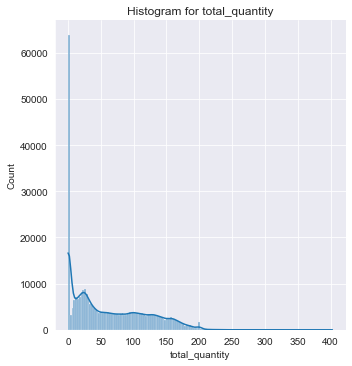

In [120]:
dist_plot(df_nut[['total_quantity']])

In [81]:
mask_over = df_nut[df_nut['total_quantity'] > 200].index
mask_zero = df_nut[df_nut['total_quantity'] == 0].index

In [82]:
df_nut.loc[mask_over]

energy_100g  fat_100g  saturated-fat_100g  caprylic-acid_100g  \
629          3586.0    100.00               14.29                 NaN   
878          1795.0     19.05               10.71                 NaN   
1035         1674.0      0.00                0.00                 NaN   
1393         2929.0     73.33               40.00                 NaN   
4730         2092.0      0.00                 NaN                 NaN   
...             ...       ...                 ...                 ...   
318708       1700.0      0.00                 NaN                 NaN   
319821       1700.0      0.00                0.00                 NaN   
319869       1401.0      0.00                0.00                 NaN   
320269       3628.0    100.00               93.33                 NaN   
320270       3628.0    100.00               93.33                 NaN   

        capric-acid_100g  lauric-acid_100g  myristic-acid_100g  \
629                  NaN               NaN                 NaN   
878                  NaN               NaN                 NaN   
1035                 NaN               NaN                 NaN   
1393                 NaN               NaN                 NaN   
4730                 NaN               NaN                 NaN   
...                  ...               ...                 ...   
318708               NaN               NaN                 NaN   
319821               NaN               NaN                 NaN   
319869               NaN               NaN                 NaN   
320269               NaN               NaN                 NaN   
320270               NaN               NaN                 NaN   

        palmitic-acid_100g  stearic-acid_100g  arachidic-acid_100g  \
629                    NaN                NaN                  NaN   
878                    NaN                NaN                  NaN   
1035                   NaN                NaN                  NaN   
1393                   NaN                NaN                  NaN   
4730                   NaN                NaN                  NaN   
...                    ...                ...                  ...   
318708                 NaN                NaN                  NaN   
319821                 NaN                NaN                  NaN   
319869                 NaN                NaN                  NaN   
320269                 NaN                NaN                  NaN   
320270                 NaN                NaN                  NaN   

        montanic-acid_100g  monounsaturated-fat_100g  \
629                    NaN                     71.43   
878                    NaN                       NaN   
1035                   NaN                       NaN   
1393                   NaN                     40.00   
4730                   NaN                       NaN   
...                    ...                       ...   
318708                 NaN                       NaN   
319821                 NaN                       NaN   
319869                 NaN                       NaN   
320269                 NaN                      5.33   
320270                 NaN                      5.33   

        polyunsaturated-fat_100g  omega-3-fat_100g  alpha-linolenic-acid_100g  \
629                        14.29               NaN                        NaN   
878                          NaN               NaN                        NaN   
1035                         NaN               NaN                        NaN   
1393                       20.00               NaN                        NaN   
4730                         NaN               NaN                        NaN   
...                          ...               ...                        ...   
318708                       NaN               NaN                        NaN   
319821                       NaN               NaN                        NaN   
319869                       NaN               NaN                        NaN   
320269        

<AxesSubplot:>

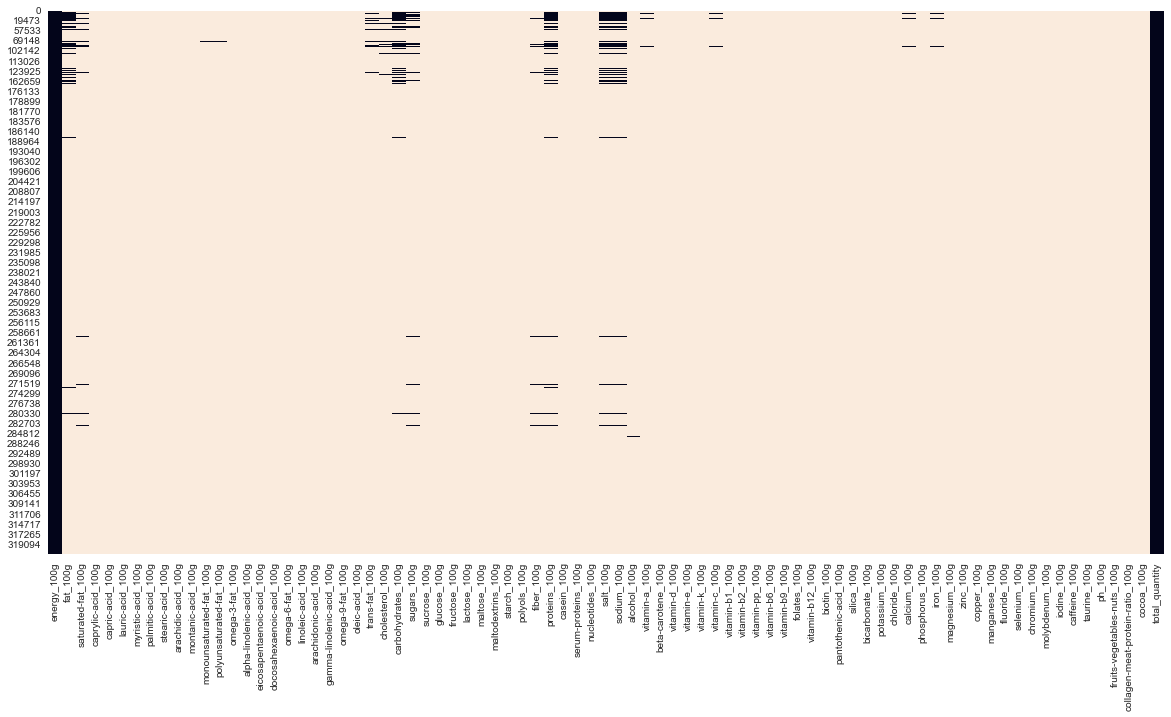

In [83]:
plt.figure(figsize=(20,10))
sns.heatmap(df_nut.loc[mask_zero].isna(), cbar=False)

In [84]:
# drop des valeurs manquantes à plus de 50 %
df_nut1 = df_nut.copy()
col_to_remove = missing_values(df_nut1, 50)
data.drop(col_to_remove, axis=1, inplace=True)

                                  missing   total    percent
caprylic-acid_100g                 320391  320392  99.999688
myristic-acid_100g                 320391  320392  99.999688
palmitic-acid_100g                 320391  320392  99.999688
stearic-acid_100g                  320391  320392  99.999688
arachidic-acid_100g                320391  320392  99.999688
montanic-acid_100g                 320391  320392  99.999688
gamma-linolenic-acid_100g          320391  320392  99.999688
capric-acid_100g                   320390  320392  99.999376
maltose_100g                       320388  320392  99.998752
lauric-acid_100g                   320388  320392  99.998752
arachidonic-acid_100g              320384  320392  99.997503
nucleotides_100g                   320383  320392  99.997191
molybdenum_100g                    320381  320392  99.996567
maltodextrins_100g                 320381  320392  99.996567
oleic-acid_100g                    320379  320392  99.995942
serum-proteins_100g     

In [85]:
df_nut1.drop('total_quantity', axis=1, inplace=True)
cols = df_nut1.columns
fill_nutriments_with_0(data , cols)

In [86]:
# df_nut.drop('total_quantity', axis=1, inplace=True)
cols = df_nut.columns
fill_nutriments_with_0(df_nut , cols)

In [87]:
df_nut.describe()

energy_100g       fat_100g  saturated-fat_100g  caprylic-acid_100g  \
count  320392.000000  320392.000000       320392.000000       320392.000000   
mean     1126.462213       9.679329            3.669464            0.000023   
std       727.293612      16.203606            7.081184            0.013073   
min         0.000000       0.000000            0.000000            0.000000   
25%       502.000000       0.000000            0.000000            0.000000   
50%      1138.000000       1.160000            0.020000            0.000000   
75%      1569.000000      14.290000            4.500000            0.000000   
max     16000.000000     100.000000          100.000000            7.400000   

       capric-acid_100g  lauric-acid_100g  myristic-acid_100g  \
count     320392.000000     320392.000000       320392.000000   
mean           0.000038          0.000451            0.000059   
std            0.015096          0.147451            0.033390   
min            0.000000          0.000000            0.000000   
25%            0.000000          0.000000            0.000000   
50%            0.000000          0.000000            0.000000   
75%            0.000000          0.000000            0.000000   
max            6.200000         49.300000           18.900000   

       palmitic-acid_100g  stearic-acid_100g  arachidic-acid_100g  \
count       320392.000000      320392.000000         3.203920e+05   
mean             0.000025           0.000009         1.997553e-07   
std              0.014310           0.005300         1.130679e-04   
min              0.000000           0.000000         0.000000e+00   
25%              0.000000           0.000000         0.000000e+00   
50%              0.000000           0.000000         0.000000e+00   
75%              0.000000           0.000000         0.000000e+00   
max              8.100000           3.000000         6.400000e-02   

       montanic-acid_100g  monounsaturated-fat_100g  polyunsaturated-fat_100g  \
count       320392.000000             320392.000000             320392.000000   
mean             0.000190                  0.740288                  0.449841   
std              0.107768                  5.193357                  3.315660   
min              0.000000                  0.000000                  0.000000   
25%              0.000000                  0.000000                  0.000000   
50%              0.000000                  0.000000                  0.000000   
75%              0.000000                  0.000000                  0.000000   
max             61.000000                100.000000                 98.000000   

       omega-3-fat_100g  alpha-linolenic-acid_100g  \
count     320392.000000              320392.000000   
mean           0.008353                   0.001306   
std            0.330097                   0.199071   
min            0.000000                   0.000000   
25%            0.000000                   0.000000   
50%            0.000000                   0.000000   
75%            0.000000                   0.000000   
max           60.000000                  75.000000   

       eicosapentaenoic-acid_100g  docosahexaenoic-acid_100g  \
count               320392.000000              320392.000000   
mean                     0.000373                   0.000127   
std                      0.153631                   0.023399   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                     85.000000                  12.000000   

       omega-6-fat_100g  linoleic-acid_100g  arachidonic-acid_100g  \
count     320392.000000       320392.000000          320392.000000   
mean           0.009523            0.001778               0.000001   
std            0.577463            0.162107               0.000309   
min            

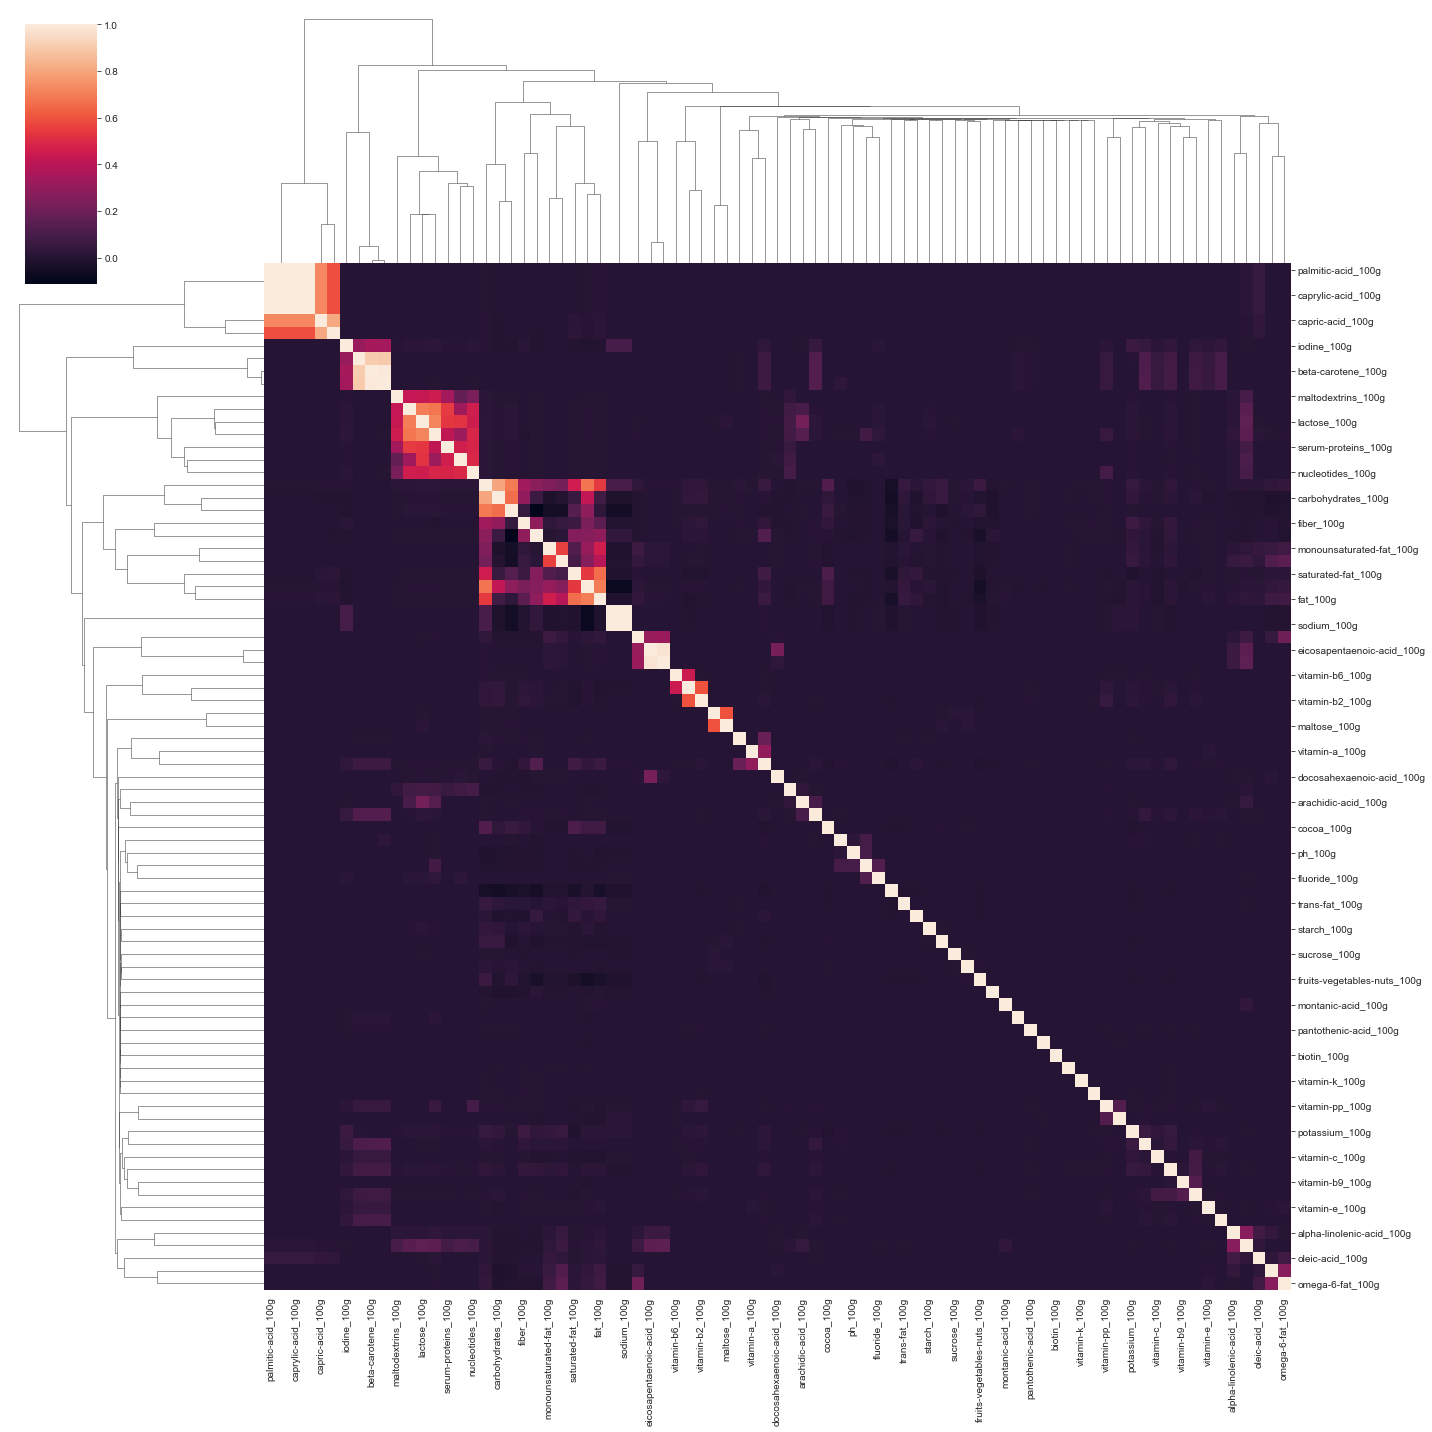

In [88]:
sns.clustermap(df_nut.corr(), figsize=(20, 20))

In [121]:
# dist_plot(df_nut)

# PCA sur les nutriments

<AxesSubplot:>

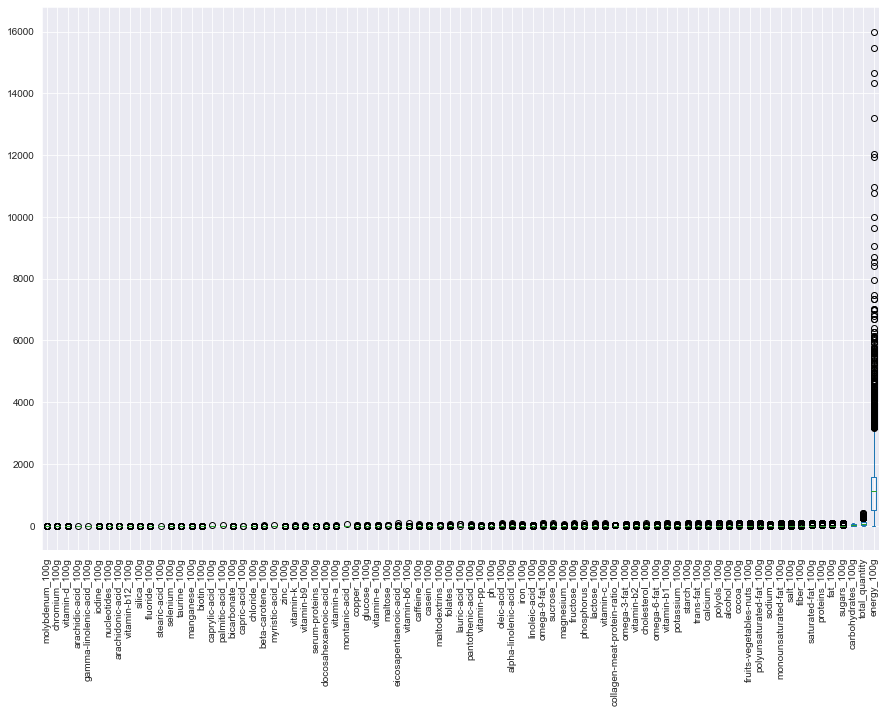

In [90]:
sort_by_mean = df_nut.mean().sort_values(ascending=True)
df_nut[sort_by_mean.index].plot(kind='box', figsize=(15, 10), rot=90)

# Centrer réduire

<AxesSubplot:>

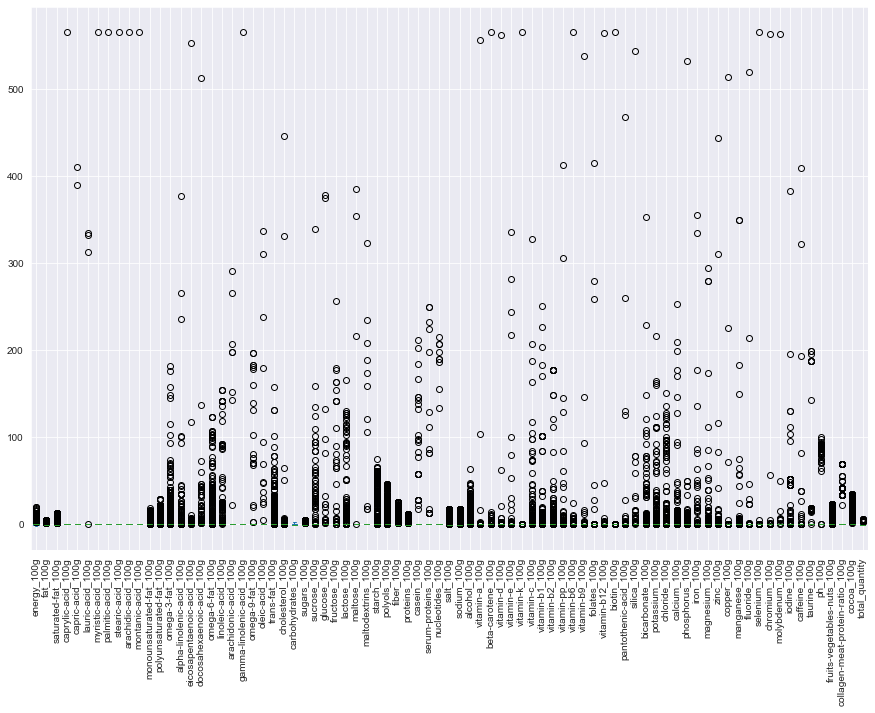

In [91]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X = df_nut.dropna()
x_scaled = std.fit_transform(X)
x_scaled = pd.DataFrame(x_scaled, columns=X.columns, index=X.index)
x_scaled.plot(kind='box', rot='90', figsize=(15,10))

# PCA

In [92]:
from sklearn.decomposition import PCA
pca = PCA(random_state=0)
X_pca = pca.fit_transform(x_scaled)
X_pca = pd.DataFrame(X_pca, columns=['PC'+ str(c) for c in range(1, X.shape[1]+1, 1)])

In [93]:
explained_variance = pd.Series(dict(zip(X_pca.columns, 100*pca.explained_variance_ratio_)))
print(explained_variance.head())

PC1    6.263772
PC2    4.827318
PC3    4.593710
PC4    3.874936
PC5    2.786473
dtype: float64


<AxesSubplot:ylabel='Explained variance'>

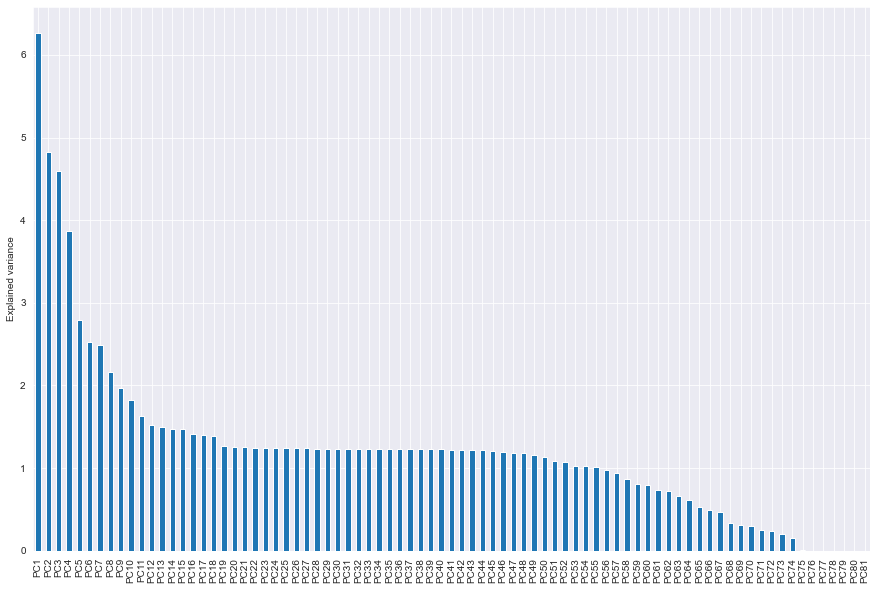

In [94]:
explained_variance.plot(kind='bar', rot='90', figsize=(15,10), ylabel='Explained variance')

In [95]:
explained_variance.cumsum()

PC1       6.263772
PC2      11.091090
PC3      15.684800
PC4      19.559737
PC5      22.346209
PC6      24.870079
PC7      27.358766
PC8      29.519783
PC9      31.494923
PC10     33.316304
PC11     34.950618
PC12     36.474733
PC13     37.972975
PC14     39.450867
PC15     40.923125
PC16     42.335914
PC17     43.739136
PC18     45.129435
PC19     46.394972
PC20     47.651098
PC21     48.901267
PC22     50.150207
PC23     51.397493
PC24     52.641664
PC25     53.882581
PC26     55.123298
PC27     56.361847
PC28     57.599220
PC29     58.835626
PC30     60.070689
PC31     61.305346
PC32     62.539925
PC33     63.774496
PC34     65.009009
PC35     66.243258
PC36     67.476446
PC37     68.707894
PC38     69.937210
PC39     71.165517
PC40     72.391370
PC41     73.614302
PC42     74.832755
PC43     76.050143
PC44     77.264968
PC45     78.473718
PC46     79.668563
PC47     80.852144
PC48     82.034689
PC49     83.196589
PC50     84.327016
PC51     85.418805
PC52     86.496059
PC53     87.

In [96]:
# from sklearn.manifold import TSNE
#
# tsne = TSNE(n_components=3, init='pca', random_state=0, n_jobs=-1)
# X_tsne = tsne.fit_transform(x_scaled)
# columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)]
# X_tsne = pd.DataFrame(X_tsne, index=X.index, columns=columns)
# X_tsne.head()

In [97]:
# La divergence de Kullback-Leibler après optimisation
# tsne.kl_divergence_

# Groupe 8

In [98]:
df_score = pd.DataFrame()
for col in data.columns:
    if col.startswith('nutrition'):
        df_score[col] = data[col]

In [99]:
df_score.stb.missing()

missing   total    percent
nutrition_grade_fr         99357  320392  31.011074
nutrition-score-fr_100g    99357  320392  31.011074
nutrition-score-uk_100g    99357  320392  31.011074

In [100]:
df_score.stb.counts()

count  unique most_freq  most_freq_count least_freq  \
nutrition_grade_fr       221035       5         d            62707          b   
nutrition-score-fr_100g  221035      55       0.0            12757       38.0   
nutrition-score-uk_100g  221035      55       0.0            13582       38.0   

                         least_freq_count  
nutrition_grade_fr                  34229  
nutrition-score-fr_100g                 1  
nutrition-score-uk_100g                 1

C:\Users\Alex\Desktop\OCR_Projet\projet_2\venv\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Alex\Desktop\OCR_Projet\projet_2\venv\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: autodetected range of [-inf, 1.6020599913279623] is not finite

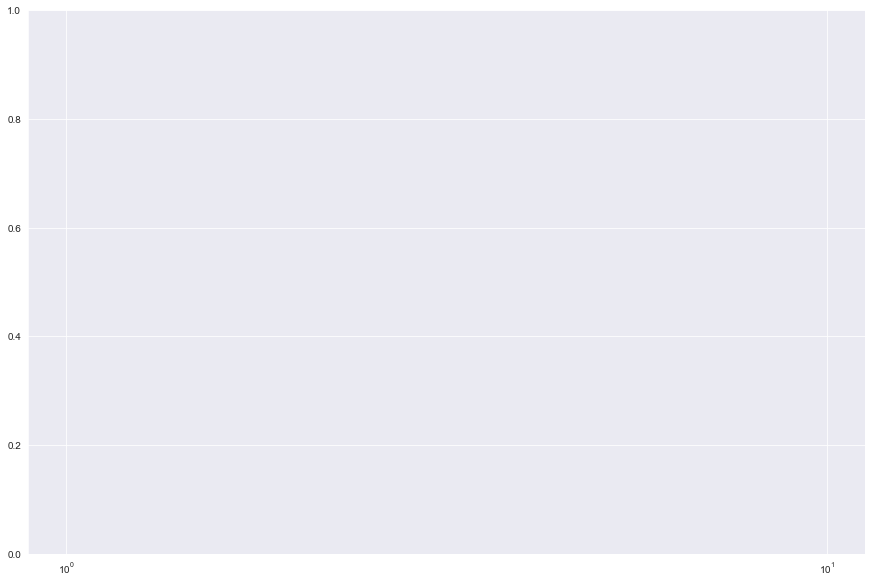

In [101]:
# dist_plot(df_score)

In [102]:
df_score['equal-result'] = df_score['nutrition-score-fr_100g'].fillna('-').eq(df_score['nutrition-score-uk_100g'].fillna('-'))
df_score[df_score['equal-result'] == False]

nutrition_grade_fr  nutrition-score-fr_100g  nutrition-score-uk_100g  \
226                     e                     13.0                      2.0   
240                     e                     13.0                      2.0   
648                     d                     11.0                     20.0   
664                     e                     12.0                      1.0   
695                     d                     14.0                     19.0   
...                   ...                      ...                      ...   
320626                  e                     13.0                      2.0   
320629                  e                     14.0                      0.0   
320656                  d                     16.0                     20.0   
320668                  c                      4.0                     -3.0   
320763                  c                      2.0                      0.0   

        equal-result  
226            False  
240            False  
648            False  
664            False  
695            False  
...              ...  
320626         False  
320629         False  
320656         False  
320668         False  
320763         False  

[8319 rows x 4 columns]

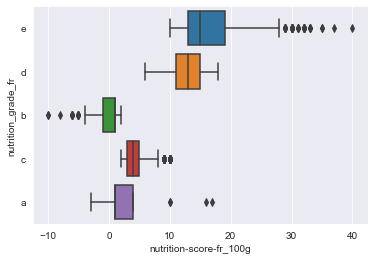

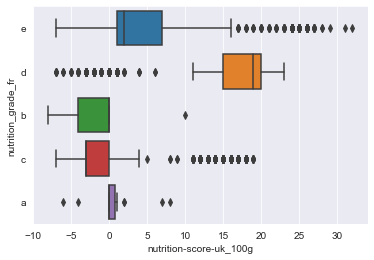

In [103]:
df_score_chg = df_score[df_score['equal-result'] == False]
for col in df_score_chg.select_dtypes('float'):
    plt.figure()
    for cat in df_score_chg['nutrition_grade_fr'].unique():
        sns.boxplot(y='nutrition_grade_fr', x=df_score_chg[df_score_chg['nutrition_grade_fr']==cat][col], data=df_score_chg)

In [104]:
# valeurs manquantes correpondent nutriscore et nutri 100g (meme ligne)

val = df_score[df_score['nutrition_grade_fr'].isna() == True]['nutrition-score-fr_100g']
val

0        NaN
4        NaN
5        NaN
6        NaN
8        NaN
          ..
320766   NaN
320767   NaN
320769   NaN
320770   NaN
320771   NaN
Name: nutrition-score-fr_100g, Length: 99357, dtype: float64

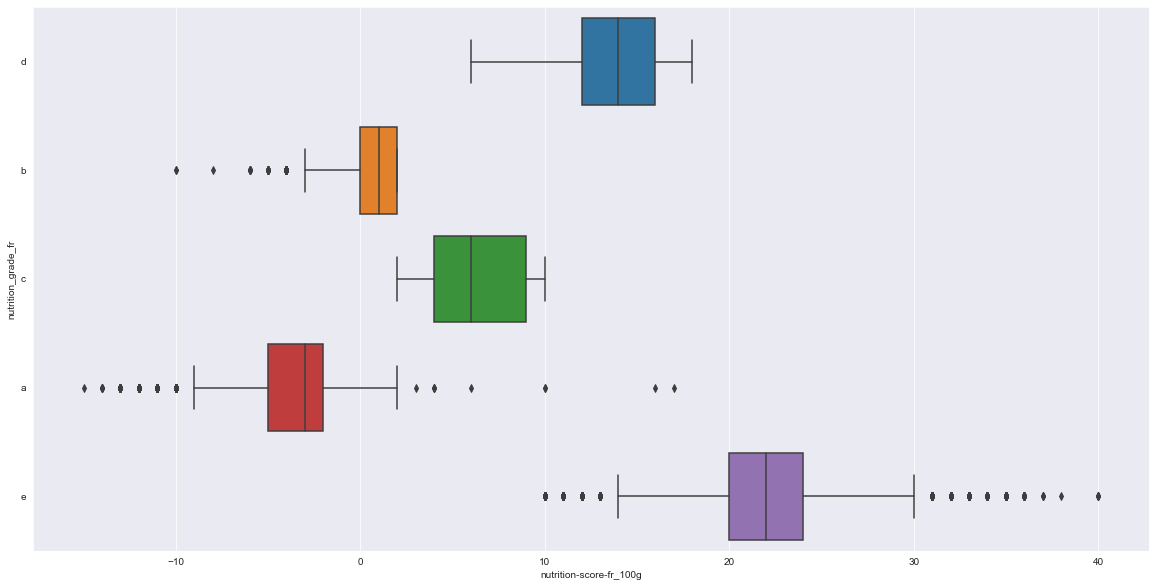

In [105]:
# distribution total de l'échantillon

plt.figure(figsize=(20,10))
for cat in df_score['nutrition_grade_fr'].sort_values().dropna().unique():

    sns.boxplot(y='nutrition_grade_fr', x=df_score[df_score['nutrition_grade_fr']==cat]['nutrition-score-fr_100g'], data=df_score)

<AxesSubplot:ylabel='nutrition_grade_fr'>

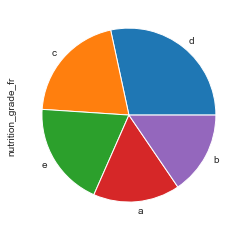

In [106]:
df_score.nutrition_grade_fr.value_counts(normalize=True).plot.pie()

In [107]:
# drop de la col uk
data.drop('nutrition-score-uk_100g', axis=1, inplace=True)

In [108]:
data.shape

(320392, 35)

# Trasformation finale

In [109]:
data.drop(['labels', 'labels_tags', 'labels_fr', 'quantity', 'serving_size','generic_name','brands_tags','categories','categories_tags','categories_fr', 'pnns_groups_2','ingredients_text', 'additives', 'additives_fr', 'main_category', 'main_category_fr'], axis=1, inplace=True)

In [110]:
data.to_csv('clean_df.csv', index=False) # ,'brands'

In [111]:
df = pd.read_csv('clean_df.csv')
df

product_name           brands  \
0                                      farine de blé noir  ferme t'y r'nao   
1                          banana chips sweetened (whole)              NaN   
2                                                 peanuts   torn & glasser   
3                                  organic salted nut mix        grizzlies   
4                                         organic polenta   bob's red mill   
...                                                   ...              ...   
320387                                  tomato & ricotta          panzani    
320388  mint melange tea a blend of peppermint, lemon ...     trader joe's   
320389                                            乐吧泡菜味薯片               乐吧   
320390                           tomates aux vermicelles             knorr   
320391                    sugar free drink mix, peach tea    market pantry   

       countries_fr  additives_n                       additives_tags  \
0            France          2.0                                  NaN   
1        États-Unis          0.0                         No additives   
2        États-Unis          0.0                         No additives   
3        États-Unis          0.0                         No additives   
4        États-Unis          0.0                         No additives   
...             ...          ...                                  ...   
320387     Roumanie          2.0                                  NaN   
320388   États-Unis          0.0                         No additives   
320389        Chine          2.0                                  NaN   
320390       France          2.0                                  NaN   
320391   États-Unis          7.0  e330,e951,e150a,e950,e552,e102,e129   

        ingredients_from_palm_oil_n  ingredients_that_may_be_from_palm_oil_n  \
0                               NaN                                      NaN   
1                               0.0                                      0.0   
2                               0.0                                      0.0   
3                               0.0                                      0.0   
4                               0.0                                      0.0   
...                             ...                                      ...   
320387                          NaN                                      NaN   
320388                          0.0                                      0.0   
320389                          NaN                                      NaN   
320390                          NaN                                      NaN   
320391                          0.0                                      0.0   

       nutrition_grade_fr         pnns_groups_1  energy_100g  fat_100g  \
0                     NaN  cereals and potatoes       1165.0      0.00   
1                       d        fat and sauces       2243.0     28.57   
2                       b          salty snacks       1941.0     17.86   
3                       d        fat and sauces       2540.0     57.14   
4                     NaN             beverages       1552.0      1.43   
...                   ...                   ...          ...       ...   
320387                NaN               unknown       1138.0      0.00   
320388                  b               unknown          0.0      0.00   
320389                NaN          salty snacks       1263.0      0.00   
320390                NaN               unknown       1138.0      0.00   
320391                NaN               unknown       2092.0      0.00   

        saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0                     0.00                0.00         0.00         0.0   
1                    28.57               64.29        14.29         3.6   
2                     0.00               60.71        17.86         7.1   
3                     5.36               17.86         3.57         7.1   
4     

In [112]:
list_product = get_cat(df,20)

100%|██████████| 9/9 [02:12<00:00, 14.67s/it]

Total words/cat found : 1579
--------------------------------------------------
[['green tea', 'beverages', ['green tea', 'green tea']], ['balsamic vinegar of modena', 'beverages', ['balsamic vinegar', 'balsamic vinegar of modena']], ['green tea', 'beverages', ['green beans', 'green tea']], ['applesauce', 'beverages', ['apple juice', 'applesauce']], ['tomato paste', 'beverages', ['tomato paste', 'tomato paste']], ['honey', 'beverages', ['honey', 'honey']], ['great northern beans', 'beverages', ['great northern beans', 'great northern beans']], ['diced tomatoes', 'beverages', ['diced tomatoes', 'diced tomatoes']], ['real mayonnaise', 'beverages', ['real mayonnaise', 'real mayonnaise']], ['drink mix', 'beverages', ['drink mix', 'drink mix']], ['great northern beans', 'beverages', ['great northern beans', 'great northern beans']], ['mandarin oranges in light syrup', 'beverages', ['mandarin oranges in light syrup', 'mandarin oranges in light syrup']], ['green tea', 'beverages', ['green bea

In [114]:
get_distance_for_product(df_cat, 'resu8', list_product)

100%|██████████| 1579/1579 [1:01:08<00:00,  2.32s/it]


22575
